In [4]:
import os
import h5py
import numpy as np
import pandas as pd
# import pysam
# from data_utils import *
from re import search

# Load settings

In [5]:
exec(open('/bi/home/wangy/MTR.method.paper/MTR_diff_endo/utils.py').read())
exec(open('/bi/home/wangy/MTR.method.paper/MTR_diff_endo/settings.py').read())

capstone.babraham.ac.uk


## Set-up environment and download data 
We will first create a directory to store the data and results

In [3]:
p = argparse.ArgumentParser( description='' )
p.add_argument( '--histone',               type=str,                       help='histone' )
p.add_argument("--ncells", help="ncells",
                    type=int)
# p.add_argument ('--slurm_array_id', type=int)
args = p.parse_args()
histone = args.histone
print(histone)

usage: ipykernel_launcher.py [-h] [--histone HISTONE] [--ncells NCELLS]
ipykernel_launcher.py: error: unrecognized arguments: --f=/bi/home/wangy/.local/share/jupyter/runtime/kernel-v2-2846294f57ST5CxsS4Y.json


SystemExit: 2

/bi/home/wangy/anaconda3/envs/scenicplus/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
histone = "H3K27ac"

In [5]:
#supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
_stderr = sys.stderr                                                         
null = open(os.devnull,'wb')

In [5]:
# !mkdir -p reference/data
# !wget -O reference/data/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5 https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5
# !wget -O reference/data/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz
# !wget -O reference/data/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz.tbi https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz.tbi
# !wget -O reference/data/hg38-blacklist.v2.bed https://raw.githubusercontent.com/aertslab/pycisTopic/master/blacklist/hg38-blacklist.v2.bed

In [6]:
import os
work_dir = io["basedir"] + "/processed/rna_dna/scenicplus/" + histone
#make a directory for to store the processed scRNA-seq data.
if not os.path.exists(work_dir):
    os.makedirs(work_dir)
io['peaks'] = '/bi/home/wangy/data/projects/scCUT_Tag_rna/E45/processed/dna/cistopic/' + histone + '_HMM_peaks.tsv'
# cistopic = 
io['cistopic'] = os.path.join(io["basedir"],"processed/dna/cistopic/" + histone + "/output/cisTopicObject.pkl" )
tmp_dir = '/bi/home/wangy/data/tmp'

PermissionError: [Errno 13] Permission denied: '/bi/home/lij/data'

## scRNA-seq preprocessing using Scanpy
First we preprocess the scRNA-seq side of the mutliome datasets. Most importantly we will use this side of the data to annotate celltypes. 

For this we will make use of [Scanpy](https://scanpy.readthedocs.io/en/stable/). 


<div class="alert alert-info">

**Note:**

You may also use [Seurat](https://satijalab.org/seurat/) (or any other tool in fact) to preprocess your data, however this will require some extra steps to import the data in python.
</div>

<div class="alert alert-info">

**Note:**

Further on in the actual SCENIC+ analysis the raw count matrix will be used.
</div>


In [9]:
import scanpy as sc
#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(5, 5), facecolor='white')

#make a directory for to store the processed scRNA-seq data.
if not os.path.exists(os.path.join(work_dir, 'scRNA')):
    os.makedirs(os.path.join(work_dir, 'scRNA'))

Read in the scRNA-seq count matrix into [AnnData](https://anndata.readthedocs.io/en/latest/) object.

In [13]:
adata = sc.read_h5ad(os.path.join(io["basedir"], 'processed/dna/cistopic/anndata.h5ad'))
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 5678 × 21256
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cellid', 'sample_bio.id', 'sub.lib', 'percent.mt', 'RNA_snn_res.0.1', 'seurat_clusters', 'celltype'
    var: 'features'

### Basic quality control

Only keep cells with at least 200 genes expressed and only keep genes which are expressed in at least 3 cells.

In [14]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

**Optionally**, predict and filter out doublets using [Scrublet](https://pubmed.ncbi.nlm.nih.gov/30954476/).

In [15]:
adata

AnnData object with n_obs × n_vars = 5678 × 20196
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cellid', 'sample_bio.id', 'sub.lib', 'percent.mt', 'RNA_snn_res.0.1', 'seurat_clusters', 'celltype', 'n_genes'
    var: 'features', 'n_cells'

In [16]:
# sc.external.pp.scrublet(adata) #estimates doublets

# adata = adata[adata.obs['predicted_doublet'] == False] #do the actual filtering
# adata

Filter based on mitochondrial counts and total counts.

In [11]:
# adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
# sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# import matplotlib.pyplot as plt
# mito_filter = 25
# n_counts_filter = 4300
# fig, axs = plt.subplots(ncols = 2, figsize = (8,4))

# sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', ax = axs[0], show=False)
# sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', ax = axs[1], show = False)
# #draw horizontal red lines indicating thresholds.
# axs[0].hlines(y = mito_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
# axs[1].hlines(y = n_counts_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
# fig.tight_layout()
# plt.show()

In [12]:
# adata = adata[adata.obs.n_genes_by_counts < n_counts_filter, :]
# adata = adata[adata.obs.pct_counts_mt < mito_filter, :]
# adata

### Data normalization

<div class="alert alert-info">

**Note:**

Below the data will be normalized and scaled. This is **only** for visualization purposes. For the actual SCENIC+ analysis we will use the raw count matrix. For this reason we save the non-normalized and non-scaled AnnData object in the raw slot before carying on.
</div>

In [17]:
adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

/bi/home/lij/env/miniconda3/envs/multiome_rna/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Let's visualize the labels

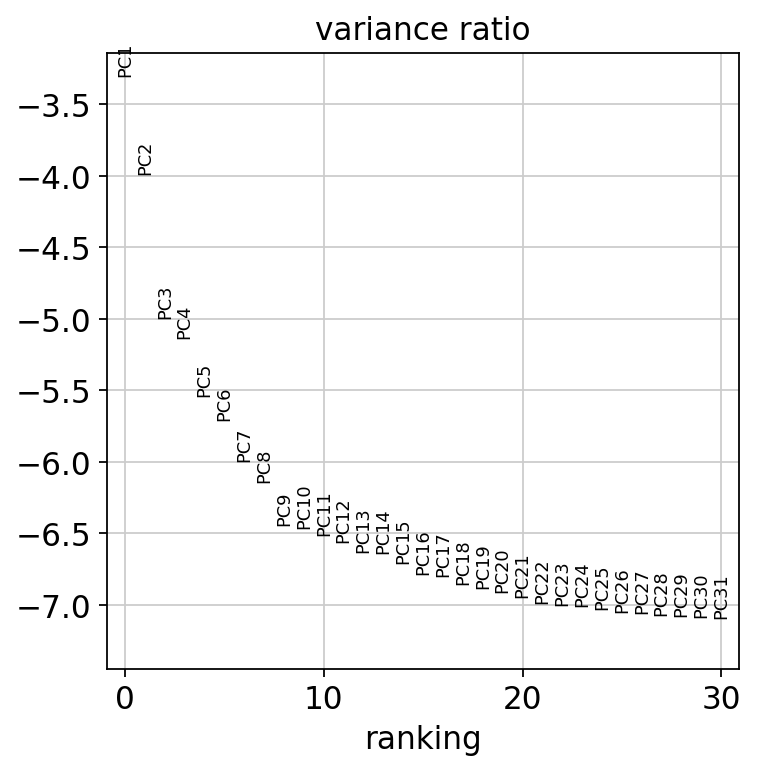

In [18]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [19]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
sc.tl.umap(adata)

/bi/home/lij/env/miniconda3/envs/multiome_rna/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


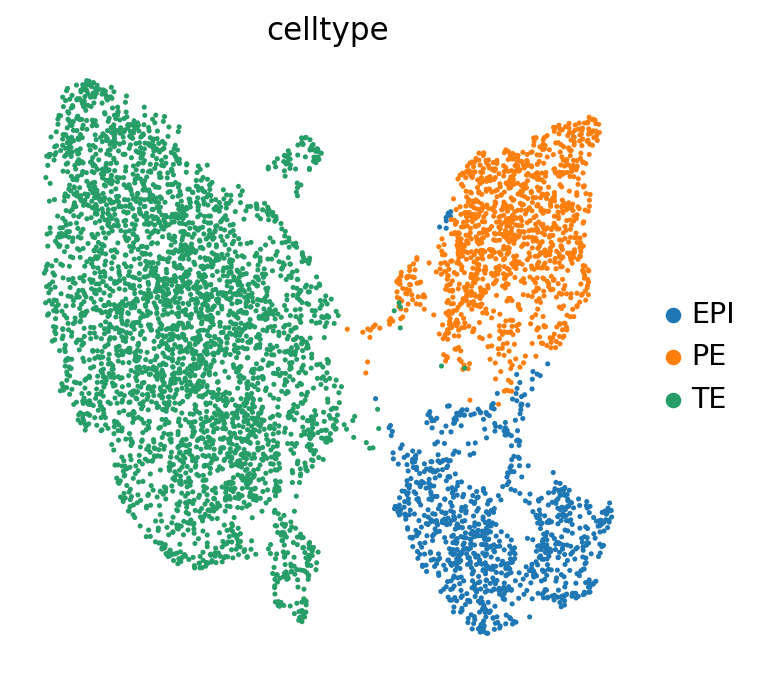

In [24]:
sc.pl.umap(adata, color = 'celltype')

ingestWe can clean the annotation a bit by running a clustering and assigning clusters to cell types based on maximum overlap.

In [20]:
# sc.tl.leiden(adata, resolution = 0.8, key_added = 'leiden_res_0.8')
# sc.pl.umap(adata, color = 'leiden_res_0.8')

### Save results

In [25]:
adata.write(os.path.join(work_dir, 'scRNA/adata.h5ad'), compression='gzip')

We now have preprocessed the scRNA-seq side of the multiome data.

In particular we have:

1. fitlered the data to only contain high quality cells.
2. annotated cells to cell types.

We also did some preliminary visualization of the data for which we needed to normalize the gene expression counts. Note that SCENIC+ uses the raw gene expression counts (i.e. without normalization and scaling). We have kept this raw data in `adata.raw`.

Now that we have clusters of annotated cells we can continue with preprocessing the scATAC-seq data. There we will use the annotated clusters of cells to generate pseudobulk ATAC-seq profiles per cell type which will be used for peak calling.

## scATAC-seq preprocessing using pycisTopic

Now we will preprocess the scATAC-seq side of the multiome data.

Most importantly we will:

1. generate pseudobulk ATAC-seq profiles per cell type and call peaks
2. merge these peaks into a consensus peak-set
3. do quality control on the scATAC-seq barcodes
4. run topic modeling to find sets of co-accessible regions and to impute chromatin accessibility resolving the issue of drop outs

For this we will use the python package [pycisTopic](https://pycistopic.readthedocs.io/en/latest/). 

<div class="alert alert-info">

**Note:**

pycisTopic can also be used for independent analysis of scATAC-seq data and has many more features which will not be demonstrated here. For more information see the read the docs page of [pycisTopic](https://pycistopic.readthedocs.io/en/latest/)
</div>

In [26]:
import os
import pycisTopic
#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline

#make a directory for to store the processed scRNA-seq data.
if not os.path.exists(os.path.join(work_dir, 'scATAC')):
    os.makedirs(os.path.join(work_dir, 'scATAC'))
tmp_dir = '/bi/home/lij/data/tmp'

Specify the location of the ATAC fragments file, this is the main input into pycisTopic.

### load the cisTopic object 

Now that we have good quality barcodes we will generate a binary count matrix of ATAC-seq fragments over consensus peaks. This matrix, along with metadata, will be stored in a cisTopic object and be used for topic modeling.

We will start by reading cell metadata from the scRNA-seq side of the analysis. For SCENIC+ we will only keep cells which passed quality metrics in both assays.

<div class="alert alert-info">

**Note:**

For independent scATAC-seq analysis you probably want to keep all cells (not only the cells passing the scRNA-seq filters). 
</div>

In [27]:
import pickle
cistopic_obj = pickle.load(open(io['cistopic'], 'rb'))
# from pycisTopic.cistopic_class import *

### Visualization

We can use the cell-topic probabilities to generate dimensionality reductions.

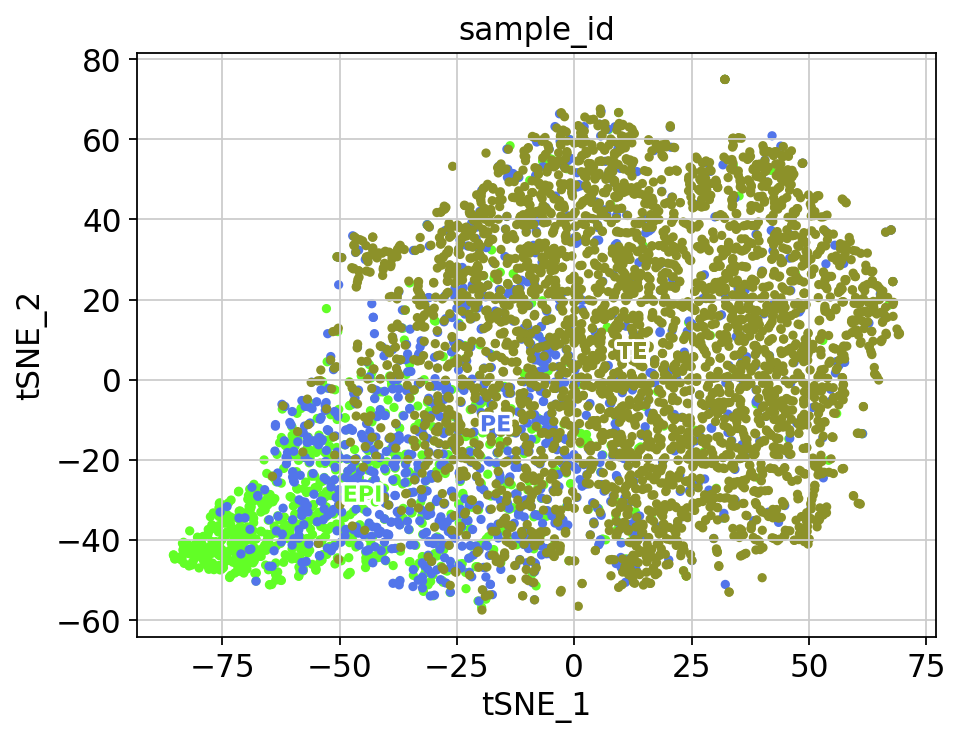

In [29]:
from pycisTopic.clust_vis import *
# run_umap(cistopic_obj, target  = 'cell', scale=True)
plot_metadata(cistopic_obj, reduction_name = 'tSNE', variables = ['sample_id'])

We can also plot the cell-topic probabilities on the UMAP, to visualize their cell type specifiticy.

For further analysis see the [pycisTopic read the docs page](https://pycistopic.readthedocs.io/en/latest/)

### Inferring candidate enhancer regions

Next we will infer candidate enhancer regions by:

1. binarization of region-topic probabilites.
2. calculation differentially accessibile regions (DARs) per cell type.

These regions will be used as input for the next step, [pycistarget](https://pycistarget.readthedocs.io/en/latest/), in which we will look which motifs are enriched in these regions.

First we will binarize the topics using the [otsu](http://ieeexplore.ieee.org/document/4310076/) method and by taking the top 3k regions per topic.

In [30]:
from pycisTopic.topic_binarization import *
region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu')
region_bin_topics_top3k = binarize_topics(cistopic_obj, method='ntop', ntop = 1000)

<Figure size 512x384 with 0 Axes>

<Figure size 512x384 with 0 Axes>

Next we will calculate DARs per cell type

In [31]:
from pycisTopic.diff_features import *
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)

2024-07-29 14:42:45,019 cisTopic     INFO     Imputing region accessibility
2024-07-29 14:42:45,020 cisTopic     INFO     Impute region accessibility for regions 0-20000
2024-07-29 14:42:48,092 cisTopic     INFO     Impute region accessibility for regions 20000-40000
2024-07-29 14:42:50,574 cisTopic     INFO     Impute region accessibility for regions 40000-60000
2024-07-29 14:42:53,232 cisTopic     INFO     Impute region accessibility for regions 60000-80000
2024-07-29 14:42:55,938 cisTopic     INFO     Impute region accessibility for regions 80000-100000
2024-07-29 14:42:58,638 cisTopic     INFO     Impute region accessibility for regions 100000-120000
2024-07-29 14:43:01,616 cisTopic     INFO     Impute region accessibility for regions 120000-140000
2024-07-29 14:43:01,772 cisTopic     INFO     Done!
2024-07-29 14:43:01,773 cisTopic     INFO     Normalizing imputed data
2024-07-29 14:43:18,676 cisTopic     INFO     Done!


2024-07-29 14:46:51,658 cisTopic     INFO     Calculating mean
2024-07-29 14:46:52,874 cisTopic     INFO     Calculating variance


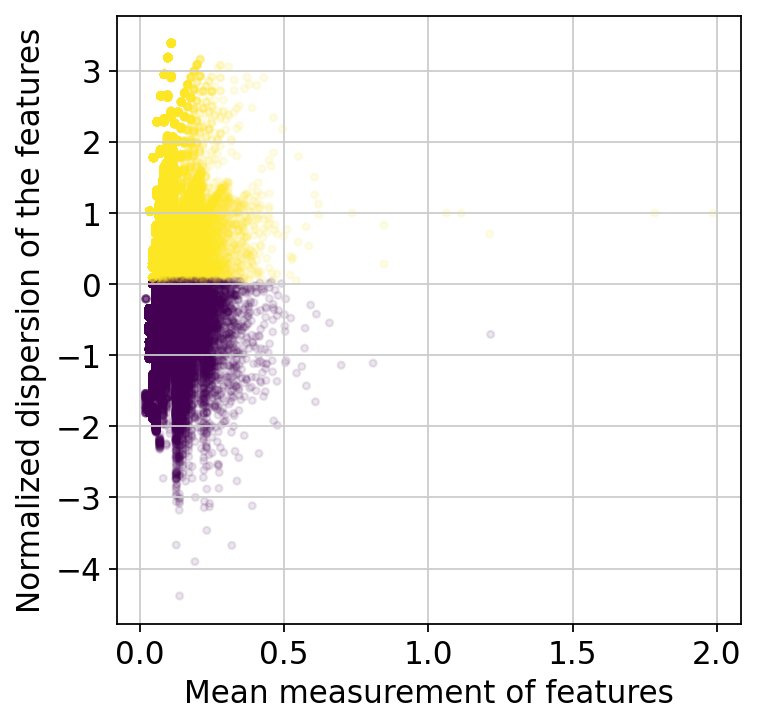

2024-07-29 14:47:31,328 cisTopic     INFO     Done!


In [35]:
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj, plot = True)

In [38]:
cistopic_obj

In [75]:
# markers_dict = find_diff_features(cistopic_obj, imputed_acc_obj, variable='sample_id', var_features=variable_regions,adjpval_thr=0.1)

Save results

In [40]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/candidate_enhancers')):
    os.makedirs(os.path.join(work_dir, 'scATAC/candidate_enhancers'))
import pickle
pickle.dump(region_bin_topics_otsu, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_otsu.pkl'), 'wb'))
pickle.dump(region_bin_topics_top3k, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_top3k.pkl'), 'wb'))
pickle.dump(markers_dict, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict.pkl'), 'wb'))

## Motif enrichment analysis using pycistarget

After having identified candidate enhancer regions we will use [pycistarget](https://pycistarget.readthedocs.io/en/latest/) to find which motifs are enriched in these regions. 

### Cistarget databases

In order to run pycistarget one needs a precomputed database containing motif scores for genomic regions.

You can choose to compute this database yourself by scoring the consensus peaks generated in the scATAC-seq analysis using a set of motifs. The advantage of creating a sample specific database is that you can potentially pick up more target regions, given that only regions included/overlappig with regions in the cistarget database will be used for the SCENIC+ analysis. For more information checkout the [create_cisTarget_databases repo on github](https://github.com/aertslab/create_cisTarget_databases). 

We also provide several precomputed databases containing regions covering many experimentally defined candidate cis-regulatory elements. These databases are available on: [https://resources.aertslab.org/cistarget/](https://resources.aertslab.org/cistarget/).

For this analysis we will use a precomputed database using [screen regions](https://screen.encodeproject.org/).

Next to a precomputed motif database we also need a motif-to-tf annotation database. This is also available on [https://resources.aertslab.org/cistarget/](https://resources.aertslab.org/cistarget/).

Load candidate enhancer regions identified in previous step.

In [41]:
import pickle
region_bin_topics_otsu = pickle.load(open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_otsu.pkl'), 'rb'))
region_bin_topics_top3k = pickle.load(open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_top3k.pkl'), 'rb'))
markers_dict = pickle.load(open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict.pkl'), 'rb'))

In [47]:
peaks = pd.read_csv(io['peaks'], sep='\t')

markers_dictConvert to dictionary of pyranges objects.

In [52]:
peaks

,x
0,chr1:3958968-3959368
1,chr1:3960040-3960440
2,chr1:3983692-3984092
3,chr1:3985856-3986256
4,chr1:3987807-3988207
...,...
27723,chrX:110268617-110269017
27724,chrX:127090728-127091128
27725,chrX:130538835-130539235
27726,chrX:130549464-130549864


In [53]:
region_bin_topics_otsu[topic]

,Topic10
chr15:75085644-75086044,0.006229
chr15:75086598-75086998,0.003133
chr7:142434257-142434657,0.002677
chr11:59810002-59810402,0.002578
chr18:9562658-9563058,0.002507
...,...
chr7:143719258-143719658,0.000214
chr12:24086602-24087002,0.000214
chr17:28265525-28265925,0.000214
chr10:60290619-60291019,0.000214


In [54]:
regions = region_bin_topics_otsu[topic].index[region_bin_topics_otsu[topic].index.str.startswith('chr')] 

In [76]:
# region_sets['DARs'] = {}
import pyranges as pr
from pycistarget.utils import region_names_to_coordinates
region_sets = {}
region_sets['topics_otsu'] = {}
region_sets['topics_top_3'] = {}
# region_sets['DARs'] = {}
for topic in region_bin_topics_otsu.keys():
    regions = region_bin_topics_otsu[topic].index[region_bin_topics_otsu[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    regions = regions.intersection(peaks.x)
    if len(regions)!= 0:
        region_sets['topics_otsu'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for topic in region_bin_topics_top3k.keys():
    regions = region_bin_topics_top3k[topic].index[region_bin_topics_top3k[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    regions = regions.intersection(peaks.x)
    region_sets['topics_top_3'][topic] = pr.PyRanges(region_names_to_coordinates(regions))

In [67]:
# for DAR in markers_dict.keys():
#     regions = markers_dict[DAR].index[markers_dict[DAR].index.str.startswith('chr')] #only keep regions on known chromosomes
#     regions = regions.intersection(peaks.x)
#     if len(regions)!= 0:
#         region_sets['DARs'][DAR] = pr.PyRanges(region_names_to_coordinates(regions))

Define rankings, score and motif annotation database.

The ranking database is used for running the cistarget analysis and the scores database is used for running the DEM analysis. For more information see [the pycistarget read the docs page](https://pycistarget.readthedocs.io/en/latest/)


In [78]:
db_fpath = "/bi/home/lij/data/cistarget/mm10"
motif_annot_fpath = "/bi/home/lij/data/cistarget/snapshots"

In [79]:
rankings_db = os.path.join(db_fpath, 'mm10_screen_v10_clust.regions_vs_motifs.rankings.feather')
scores_db =  os.path.join(db_fpath, 'mm10_screen_v10_clust.regions_vs_motifs.scores.feather')
motif_annotation = os.path.join(motif_annot_fpath, 'motifs-v10-nr.mgi-m0.00001-o0.0.tbl')

Next we will run pycistarget using the `run_pycistarget` wrapper function.

This function will run cistarget based and DEM based motif enrichment analysis with or without promoter regions.


In [80]:
if not os.path.exists(os.path.join(work_dir, 'motifs')):
    os.makedirs(os.path.join(work_dir, 'motifs'))

In [109]:
from scenicplus.wrappers.run_pycistarget import run_pycistarget
run_pycistarget(
    region_sets = region_sets,
    species = 'mus_musculus',
    save_path = os.path.join(work_dir, 'motifs'),
    ctx_db_path = rankings_db,
    dem_db_path = scores_db,
    path_to_motif_annotations = motif_annotation,
    run_without_promoters = True,
    n_cpu = 1,
    _temp_dir = os.path.join(tmp_dir, 'ray_spill'),
    annotation_version = 'v10nr_clust',
    )

2024-07-29 16:35:22,623 pycisTarget_wrapper INFO     /bi/home/lij/data/projects/scCUT_Tag_rna/E45/processed/rna_dna/scenicplus/H3K27ac/motifs folder already exists.
2024-07-29 16:35:32,033 pycisTarget_wrapper INFO     Loading cisTarget database for topics_otsu
2024-07-29 16:35:32,035 cisTarget    INFO     Reading cisTarget database
2024-07-29 16:36:08,956 pycisTarget_wrapper INFO     Running cisTarget for topics_otsu
2024-07-29 16:36:08,957 cisTarget    INFO     Running cisTarget for Topic1 which has 1219 regions
2024-07-29 16:36:24,304 cisTarget    INFO     Annotating motifs for Topic1
2024-07-29 16:36:27,110 cisTarget    INFO     Getting cistromes for Topic1
2024-07-29 16:36:27,389 cisTarget    INFO     Running cisTarget for Topic2 which has 1045 regions
2024-07-29 16:36:44,735 cisTarget    INFO     Annotating motifs for Topic2
2024-07-29 16:36:46,610 cisTarget    INFO     Getting cistromes for Topic2
2024-07-29 16:36:46,805 cisTarget    INFO     Running cisTarget for Topic3 which ha

In [110]:
import dill
menr = dill.load(open(os.path.join(work_dir, 'motifs/menr.pkl'), 'rb'))

We now have completed all the steps necessary for starting the SCENIC+ analysis 😅.

In particalular, we have

1. preprocessed the scRNA-seq side of the data, selecting high quality cells and annotation these cells.
2. preprocessed the scATAC-seq side of the data, selecting high quality cells, performing topic modeling and identifying candidate enhacer regions.
3. looked for enriched motifs in candidate enhancer regions.

In the next section we will combine all these analysis and run SCENIC+


## inferring enhancer-driven Gene Regulatory Networks (eGRNs) using SCENIC+

We now have completed all the steps for running the SCENIC+ analysis. 

We will start by creating a scenicplus object containing all the analysis we have done up to this point.

For this we will need to load:

1. the AnnData object containing the scRNA-seq side of the analysis.
2. the cisTopic object containing the scATAC-seq side of the analysis.
3. the motif enrichment dictionary containing the motif enrichment results.

In [111]:
import dill
import scanpy as sc
import os
import warnings
warnings.filterwarnings("ignore")
import pandas
import pyranges
# Set stderr to null to avoid strange messages from ray
import sys
_stderr = sys.stderr                                                         
null = open(os.devnull,'wb')
# work_dir = 'reference'
tmp_dir = '/bi/home/lij/data/tmp'
data_dir = io["basedir"] + "/processed/rna_dna/scenicplus"
adata = sc.read_h5ad(os.path.join(work_dir, 'scRNA/adata.h5ad'))
cistopic_obj = dill.load(open(io['cistopic'], 'rb'))
menr = dill.load(open(os.path.join(work_dir, 'motifs/menr.pkl'), 'rb'))

Create the SCENIC+ object. It will store both the gene expression and chromatin accessibility along with motif enrichment results and cell/region/gene metadata.

Cell metadata comming from the cistopic_obj will be prefixed with the string `ACC_` and metadata comming from the adata object will be prefixed with the string `GEX_`.

In [112]:
adata.obs_names = adata.obs_names + '___' + adata.obs['celltype'].tolist()

In [113]:
from scenicplus.scenicplus_class import create_SCENICPLUS_object
import numpy as np
scplus_obj = create_SCENICPLUS_object(
    GEX_anndata = adata.raw.to_adata(),
    cisTopic_obj = cistopic_obj,
    menr = menr
#     bc_transform_func = lambda x: f'{x}___cisTopic' #function to convert scATAC-seq barcodes to scRNA-seq ones
)
scplus_obj.X_EXP = np.array(scplus_obj.X_EXP.todense())
scplus_obj

2024-07-29 16:53:12,734 cisTopic     INFO     Imputing region accessibility
2024-07-29 16:53:12,735 cisTopic     INFO     Impute region accessibility for regions 0-20000
2024-07-29 16:53:18,841 cisTopic     INFO     Impute region accessibility for regions 20000-40000
2024-07-29 16:53:24,796 cisTopic     INFO     Impute region accessibility for regions 40000-60000
2024-07-29 16:53:30,340 cisTopic     INFO     Impute region accessibility for regions 60000-80000
2024-07-29 16:53:35,798 cisTopic     INFO     Impute region accessibility for regions 80000-100000
2024-07-29 16:53:40,667 cisTopic     INFO     Impute region accessibility for regions 100000-120000
2024-07-29 16:53:45,513 cisTopic     INFO     Impute region accessibility for regions 120000-140000
2024-07-29 16:53:45,603 cisTopic     INFO     Done!


SCENIC+ object with n_cells x n_genes = 5573 x 20196 and n_cells x n_regions = 5573 x 121479
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'features', 'n_cells'
	metadata_cell:'GEX_orig.ident', 'GEX_nCount_RNA', 'GEX_nFeature_RNA', 'GEX_cellid', 'GEX_sample_bio.id', 'GEX_sub.lib', 'GEX_percent.mt', 'GEX_RNA_snn_res.0.1', 'GEX_seurat_clusters', 'GEX_celltype', 'GEX_n_genes', 'ACC_cisTopic_nr_frag', 'ACC_cisTopic_log_nr_frag', 'ACC_cisTopic_nr_acc', 'ACC_cisTopic_log_nr_acc', 'ACC_sample_id', 'ACC_Log_total_nr_frag', 'ACC_Log_unique_nr_frag', 'ACC_Total_nr_frag', 'ACC_Unique_nr_frag', 'ACC_Dupl_nr_frag', 'ACC_Dupl_rate', 'ACC_Total_nr_frag_in_regions', 'ACC_Unique_nr_frag_in_regions', 'ACC_FRIP', 'ACC_TSS_enrichment', 'ACC_barcode'
	menr:'CTX_topics_otsu_All', 'CTX_topics_otsu_No_promoters', 'DEM_topics_otsu_All', 'DEM_topics_otsu_No_promoters', 'CTX_topics_top_3_All', 'CTX_top

In [114]:
scplus_obj

SCENIC+ object with n_cells x n_genes = 5573 x 20196 and n_cells x n_regions = 5573 x 121479
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'features', 'n_cells'
	metadata_cell:'GEX_orig.ident', 'GEX_nCount_RNA', 'GEX_nFeature_RNA', 'GEX_cellid', 'GEX_sample_bio.id', 'GEX_sub.lib', 'GEX_percent.mt', 'GEX_RNA_snn_res.0.1', 'GEX_seurat_clusters', 'GEX_celltype', 'GEX_n_genes', 'ACC_cisTopic_nr_frag', 'ACC_cisTopic_log_nr_frag', 'ACC_cisTopic_nr_acc', 'ACC_cisTopic_log_nr_acc', 'ACC_sample_id', 'ACC_Log_total_nr_frag', 'ACC_Log_unique_nr_frag', 'ACC_Total_nr_frag', 'ACC_Unique_nr_frag', 'ACC_Dupl_nr_frag', 'ACC_Dupl_rate', 'ACC_Total_nr_frag_in_regions', 'ACC_Unique_nr_frag_in_regions', 'ACC_FRIP', 'ACC_TSS_enrichment', 'ACC_barcode'
	menr:'CTX_topics_otsu_All', 'CTX_topics_otsu_No_promoters', 'DEM_topics_otsu_All', 'DEM_topics_otsu_No_promoters', 'CTX_topics_top_3_All', 'CTX_top

<div class="alert alert-info">

**Note:**

the scenicplus package contains many function, if you need help with any of them just run the `help()` function. For example see below:
</div>

In [115]:
from scenicplus.scenicplus_class import create_SCENICPLUS_object
help(create_SCENICPLUS_object)

Help on function create_SCENICPLUS_object in module scenicplus.scenicplus_class:

create_SCENICPLUS_object(GEX_anndata: anndata._core.anndata.AnnData, cisTopic_obj: pycisTopic.cistopic_class.CistopicObject, menr: Mapping[str, Mapping[str, Any]], multi_ome_mode: bool = True, nr_metacells: Union[int, Mapping[str, int]] = None, nr_cells_per_metacells: Union[int, Mapping[str, int]] = 10, meta_cell_split: str = '_', key_to_group_by: str = None, imputed_acc_obj: pycisTopic.diff_features.CistopicImputedFeatures = None, imputed_acc_kwargs: Mapping[str, Any] = {'scale_factor': 1000000}, normalize_imputed_acc: bool = False, normalize_imputed_acc_kwargs: Mapping[str, Any] = {'scale_factor': 10000}, cell_metadata: pandas.core.frame.DataFrame = None, region_metadata: pandas.core.frame.DataFrame = None, gene_metadata: pandas.core.frame.DataFrame = None, bc_transform_func: Callable = None, ACC_prefix: str = 'ACC_', GEX_prefix: str = 'GEX_') -> scenicplus.scenicplus_class.SCENICPLUS
    Function to cr

Before running SCENIC+ it is important to check with which biomart host the gene names used in your analysis match best. Biomart will be used to find transcription starting sites of each gene. The names of genes (symbols) change quite often, so it is important to select the biomart host with the largest overlap, otherwise a lot of genes can potentially be lost. 

Below we show an example on how to select the optimal host.

In [116]:
ensembl_version_dict = {'105': 'http://www.ensembl.org',
                        '104': 'http://may2021.archive.ensembl.org/',
                        '103': 'http://feb2021.archive.ensembl.org/',
                        '102': 'http://nov2020.archive.ensembl.org/',
                        '101': 'http://aug2020.archive.ensembl.org/',                        
                        '100': 'http://apr2020.archive.ensembl.org/',
                        '99': 'http://jan2020.archive.ensembl.org/',
                        '98': 'http://sep2019.archive.ensembl.org/',
                        '97': 'http://jul2019.archive.ensembl.org/',
                        '96': 'http://apr2019.archive.ensembl.org/',
                        '95': 'http://jan2019.archive.ensembl.org/',
                        '94': 'http://oct2018.archive.ensembl.org/',
                        '93': 'http://jul2018.archive.ensembl.org/',                        
                        '92': 'http://apr2018.archive.ensembl.org/',
                        '91': 'http://dec2017.archive.ensembl.org/',
                        '90': 'http://aug2017.archive.ensembl.org/',
                        '89': 'http://may2017.archive.ensembl.org/',      
                        '88': 'http://mar2017.archive.ensembl.org/',
                        '87': 'http://dec2016.archive.ensembl.org/',
                        '86': 'http://oct2016.archive.ensembl.org/',
                        '80': 'http://may2015.archive.ensembl.org/',
                        '77': 'http://oct2014.archive.ensembl.org/',
                        '75': 'http://feb2014.archive.ensembl.org/',
                        '54': 'http://may2009.archive.ensembl.org/'}
    
import pybiomart as pbm
def test_ensembl_host(scplus_obj, host, species):
    dataset = pbm.Dataset(name=species+'_gene_ensembl',  host=host)
    annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
    annot.columns = ['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
    annot['Chromosome'] = annot['Chromosome'].astype('str')
    filter = annot['Chromosome'].str.contains('CHR|GL|JH|MT')
    annot = annot[~filter]
    annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
    gene_names_release = set(annot['Gene'].tolist())
    ov=len([x for x in scplus_obj.gene_names if x in gene_names_release])
    print('Genes recovered: ' + str(ov) + ' out of ' + str(len(scplus_obj.gene_names)))
    return ov

n_overlap = {}
for version in ensembl_version_dict.keys():
    print(f'host: {version}')
    try:
        n_overlap[version] =  test_ensembl_host(scplus_obj, ensembl_version_dict[version], 'mmusculus')
    except:
        print('Host not reachable')
v = sorted(n_overlap.items(), key=lambda item: item[1], reverse=True)[0][0]
print(f"version: {v} has the largest overlap, use {ensembl_version_dict[v]} as biomart host")

host: 105
Genes recovered: 19397 out of 20196
host: 104
Genes recovered: 19864 out of 20196
host: 103
Genes recovered: 19874 out of 20196
host: 102
Genes recovered: 20029 out of 20196
host: 101
Genes recovered: 20029 out of 20196
host: 100
Genes recovered: 20029 out of 20196
host: 99
Genes recovered: 20080 out of 20196
host: 98
Genes recovered: 20174 out of 20196
host: 97
Host not reachable
host: 96
Host not reachable
host: 95
Host not reachable
host: 94
Host not reachable
host: 93
Host not reachable
host: 92
Host not reachable
host: 91
Host not reachable
host: 90
Host not reachable
host: 89
Host not reachable
host: 88
Host not reachable
host: 87
Host not reachable
host: 86
Host not reachable
host: 80
Genes recovered: 17518 out of 20196
host: 77
Genes recovered: 16933 out of 20196
host: 75
Host not reachable
host: 54
Host not reachable
version: 98 has the largest overlap, use http://sep2019.archive.ensembl.org/ as biomart host


Once the object is created we can run SCENIC+. The whole analysis workflow can be run using a single wrapper function or each step can be run individually.

<div class="alert alert-info">

**Note:**

Here we will use the wrapper function. For more information on the different steps, see the following tutorial: TO BE ADDED. 
</div>

In [117]:
biomart_host = "http://sep2019.archive.ensembl.org/"

Before running we will also download a list of known human TFs from the [human transcription factors database](http://humantfs.ccbr.utoronto.ca/).

In [118]:
#only keep the first two columns of the PCA embedding in order to be able to visualize this in SCope
scplus_obj.dr_cell['GEX_X_pca'] = scplus_obj.dr_cell['GEX_X_pca'].iloc[:, 0:2]
# scplus_obj.dr_cell['GEX_rep'] = scplus_obj.dr_cell['GEX_rep'].iloc[:, 0:2]

Now we are ready to run the analysis. 

<div class="alert alert-warning">

**Warning:**

Running SCENIC+ can be computationaly expensive. We don't recommend to run it on your local machine.
</div>

In [119]:
scplus_obj

SCENIC+ object with n_cells x n_genes = 5573 x 20196 and n_cells x n_regions = 5573 x 121479
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'features', 'n_cells'
	metadata_cell:'GEX_orig.ident', 'GEX_nCount_RNA', 'GEX_nFeature_RNA', 'GEX_cellid', 'GEX_sample_bio.id', 'GEX_sub.lib', 'GEX_percent.mt', 'GEX_RNA_snn_res.0.1', 'GEX_seurat_clusters', 'GEX_celltype', 'GEX_n_genes', 'ACC_cisTopic_nr_frag', 'ACC_cisTopic_log_nr_frag', 'ACC_cisTopic_nr_acc', 'ACC_cisTopic_log_nr_acc', 'ACC_sample_id', 'ACC_Log_total_nr_frag', 'ACC_Log_unique_nr_frag', 'ACC_Total_nr_frag', 'ACC_Unique_nr_frag', 'ACC_Dupl_nr_frag', 'ACC_Dupl_rate', 'ACC_Total_nr_frag_in_regions', 'ACC_Unique_nr_frag_in_regions', 'ACC_FRIP', 'ACC_TSS_enrichment', 'ACC_barcode'
	menr:'CTX_topics_otsu_All', 'CTX_topics_otsu_No_promoters', 'DEM_topics_otsu_All', 'DEM_topics_otsu_No_promoters', 'CTX_topics_top_3_All', 'CTX_top

In [ ]:
from scenicplus.wrappers.run_scenicplus import run_scenicplus
try:
    run_scenicplus(
        scplus_obj = scplus_obj,
        variable = ['sample_id'],
        species = 'mmusculus',
        assembly = 'mm10',
        tf_file = data_dir +'/reference/mm_mgi_tfs.txt',
        save_path = os.path.join(work_dir, 'scenicplus'),
        biomart_host = biomart_host,
        upstream = [1000, 150000],
        downstream = [1000, 150000],
        calculate_TF_eGRN_correlation = True,
        calculate_DEGs_DARs = True,
        export_to_loom_file = True,
        export_to_UCSC_file = True,
        path_bedToBigBed = data_dir + '/reference',
        n_cpu = 12,
        _temp_dir = os.path.join(tmp_dir, 'ray_spill'))
except Exception as e:
    #in case of failure, still save the object
    dill.dump(scplus_obj, open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'wb'), protocol=-1)
    raise(e)

2024-07-29 16:57:47,901 SCENIC+_wrapper INFO     Created folder : /bi/home/lij/data/projects/scCUT_Tag_rna/E45/processed/rna_dna/scenicplus/H3K27ac/scenicplus
2024-07-29 16:57:47,902 SCENIC+_wrapper INFO     Merging cistromes
2024-07-29 16:57:54,637 SCENIC+_wrapper INFO     Getting search space
2024-07-29 16:57:55,188 R2G          INFO     Downloading gene annotation from biomart dataset: mmusculus_gene_ensembl
2024-07-29 16:58:02,188 R2G          INFO     Downloading chromosome sizes from: http://hgdownload.cse.ucsc.edu/goldenPath/mm10/bigZips/mm10.chrom.sizes
2024-07-29 16:58:05,361 R2G          INFO     Extending promoter annotation to 10 bp upstream and 10 downstream
2024-07-29 16:58:06,227 R2G          INFO     Extending search space to:
            						150000 bp downstream of the end of the gene.
            						150000 bp upstream of the start of the gene.
2024-07-29 16:58:10,743 R2G          INFO     Intersecting with regions.


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


2024-07-29 16:58:11,300 R2G          INFO     Calculating distances from region to gene
2024-07-29 16:59:26,030 R2G          INFO     Imploding multiple entries per region and gene
2024-07-29 17:01:35,796 R2G          INFO     Done!
2024-07-29 17:01:36,066 SCENIC+_wrapper INFO     Inferring region to gene relationships
2024-07-29 17:01:36,194 R2G          INFO     Calculating region to gene importances, using GBM method


2024-07-29 17:02:03,120	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
Running using 12 cores: 100%|██████████████████████████████████████████████████████████████████████████████████████| 15792/15792 [05:36<00:00, 46.95it/s]
(pid=2165658) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject [repeated 11x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


2024-07-29 17:17:49,196 R2G          INFO     Took 973.0008533000946 seconds
2024-07-29 17:17:49,197 R2G          INFO     Calculating region to gene correlation, using SR method


2024-07-29 17:17:56,760	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
Running using 12 cores: 100%|█████████████████████████████████████████████████████████████████████████████████████| 15792/15792 [01:02<00:00, 251.72it/s]
(pid=2198842) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject [repeated 11x across cluster]


2024-07-29 17:28:45,413 R2G          INFO     Took 656.2146654129028 seconds
2024-07-29 17:29:00,420 R2G          INFO     Done!
2024-07-29 17:29:00,724 SCENIC+_wrapper INFO     Inferring TF to gene relationships


2024-07-29 17:29:12,222	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


2024-07-29 17:29:12,897 TF2G         INFO     Calculating TF to gene correlation, using GBM method


initializing:   0%|▎                                                                                                | 66/20196 [00:32<2:02:47,  2.73it/s](raylet) Spilled 3156 MiB, 20 objects, write throughput 138 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(pid=2230522) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject [repeated 11x across cluster]
initializing:  28%|██████████████████████████▌                                                                    | 5650/20196 [40:11<2:27:27,  1.64it/s]

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: dae678f96e64cb215e5bb7cabf67bbf84181d23001000000 Worker ID: 3589920ff989e90a53f77122e09cafe0a68ee5b8046cbbdfb0ce02cc Node ID: 485d1e3406edbc171fb7d94662d94574165d02dab7b81506c0379719 Worker IP address: 149.155.145.19 Worker port: 40105 Worker PID: 2230532 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 2. End of file. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray stop --force is called. (3) The worker is crashed unexpectedly due to SIGSEGV or other unexpected errors.


initializing:  29%|███████████████████████████▍                                                                   | 5842/20196 [45:41<2:04:04,  1.93it/s](pid=2373822) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(raylet) [2024-07-29 18:12:54,558 E 2230406 2230406] (raylet) worker_pool.cc:553: Some workers of the worker process(2371096) have not registered within the timeout. The process is still alive, probably it's hanging during start.
initializing:  47%|███████████████████████████████████████████▉                                                 | 9533/20196 [1:14:42<2:33:02,  1.16it/s]

In [113]:
dill.dump(scplus_obj, open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'wb'), protocol=-1)

## Note on the output of SCENIC+

After running the SCENIC+ analysis the `scplus_obj` will be populated with the results of several analysis. Below we will describe how you can explore these.

For structuring this data we took inspiration from the [AnnData](https://anndata.readthedocs.io/en/latest/) format.

### Gene expression and chromatin accessibility data

Both the raw gene expression counts and chromatin accessibility data are stored in the `scplus_obj` and can be accessed by running, `scplus_obj.to_df('EXP')` or `scplus_obj.to_df('ACC')`.

In [6]:
work_dir = '/bi/home/wangy/MTR.method.paper/data'
save_path = os.path.join(work_dir, 'scenicplus.e45')

In [7]:
import dill
# # work_dir = 'reference'
scplus_obj = dill.load(open(os.path.join(save_path, 'scplus_obj.pkl'), 'rb'))
# scplus_obj = dill.load(open(os.path.join(save_path, 'scplus_obj_mod.pkl'), 'rb')
# scplus_obj = dill.load(open(os.path.join(save_path, 'scplus_obj_processed.pkl'), 'rb'))

In [8]:
scplus_obj 

SCENIC+ object with n_cells x n_genes = 5573 x 20196 and n_cells x n_regions = 5573 x 121479
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'features', 'n_cells'
	metadata_cell:'GEX_orig.ident', 'GEX_nCount_RNA', 'GEX_nFeature_RNA', 'GEX_cellid', 'GEX_sample_bio.id', 'GEX_sub.lib', 'GEX_percent.mt', 'GEX_RNA_snn_res.0.1', 'GEX_seurat_clusters', 'GEX_celltype', 'GEX_n_genes', 'ACC_cisTopic_nr_frag', 'ACC_cisTopic_log_nr_frag', 'ACC_cisTopic_nr_acc', 'ACC_cisTopic_log_nr_acc', 'ACC_sample_id', 'ACC_Log_total_nr_frag', 'ACC_Log_unique_nr_frag', 'ACC_Total_nr_frag', 'ACC_Unique_nr_frag', 'ACC_Dupl_nr_frag', 'ACC_Dupl_rate', 'ACC_Total_nr_frag_in_regions', 'ACC_Unique_nr_frag_in_regions', 'ACC_FRIP', 'ACC_TSS_enrichment', 'ACC_barcode'
	menr:'CTX_topics_otsu_All', 'CTX_topics_otsu_No_promoters', 'DEM_topics_otsu_All', 'DEM_topics_otsu_No_promoters', 'CTX_topics_top_3_All', 'CTX_top

In [12]:
scplus_obj.to_df('EXP').head()

,0610005C13Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610030E20Rik,0610031O16Rik,...,Tfap2b,Tgm6,Tmem132cos,Tmem169,Tmem74bos,Trim10,Tubal3,Upk3bl,Vmn1r68,Vpreb1
05:23:22:S1___TE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43:17:24:S4___TE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35:08:43:S2___TE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
04:41:45:S2___PE,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01:03:25:S4___TE,0.0,2.0,0.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
scplus_obj.to_df('ACC').head()

,05:23:22:S1___TE,43:17:24:S4___TE,35:08:43:S2___TE,04:41:45:S2___PE,01:03:25:S4___TE,23:45:40:S4___TE,01:22:46:S4___EPI,03:12:03:S2___TE,18:06:11:S4___TE,29:30:43:S4___TE,...,17:33:23:S4___TE,28:31:36:S2___PE,48:32:15:S4___TE,17:08:23:S1___TE,26:30:48:S2___PE,07:25:10:S1___TE,34:03:26:S2___TE,27:04:20:S1___PE,47:08:48:S1___PE,34:39:11:S2___PE
chr12:76317195-76317595,9,8,8,7,7,8,11,5,5,8,...,11,7,11,11,6,8,8,8,8,12
chr10:45072584-45072984,19,21,25,23,22,24,23,20,22,22,...,19,22,20,28,29,22,23,22,25,21
chr3:22028398-22028798,8,6,7,7,7,11,3,4,8,8,...,6,7,8,6,7,10,8,7,7,7
chr4:140708359-140708759,8,8,9,7,7,7,12,7,6,8,...,11,7,10,10,7,6,7,8,9,11
chr6:117827642-117828042,7,7,9,8,9,9,7,7,9,9,...,8,9,7,10,10,9,9,7,8,7


### Cell, region and gene metadata

Cell metatdata is stored in the `.metadata_cell` slot. Data comming from the gene expression side is prefixed with the string `GEX_` ad data comming from the chromatin accessibility side is prefixed with the string `ACC_`.

Region metadata is stored in the `.metadata_region` slot.

Gene metadata is stored in the `.metadata_gene` slot.

In [14]:
from collections import Counter

In [15]:
Counter(scplus_obj.metadata_cell.GEX_celltype)

Counter({'TE': 3557, 'PE': 1109, 'EPI': 907})

In [16]:
scplus_obj.metadata_cell.head()

,GEX_orig.ident,GEX_nCount_RNA,GEX_nFeature_RNA,GEX_cellid,GEX_sample_bio.id,GEX_sub.lib,GEX_percent.mt,GEX_RNA_snn_res.0.1,GEX_seurat_clusters,GEX_celltype,...,ACC_Log_unique_nr_frag,ACC_Total_nr_frag,ACC_Unique_nr_frag,ACC_Dupl_nr_frag,ACC_Dupl_rate,ACC_Total_nr_frag_in_regions,ACC_Unique_nr_frag_in_regions,ACC_FRIP,ACC_TSS_enrichment,ACC_barcode
05:23:22:S1___TE,S1,4103.0,1307,S1_05:23:22:01,E45_1,S1,0.000000,0,0,TE,...,2.378398,239,239,0,0.0,88,88,0.368201,0.155,05:23:22:S1
43:17:24:S4___TE,S4,5843.0,1687,S4_43:17:24:01,E45_1,S4,0.000000,0,0,TE,...,2.222716,167,167,0,0.0,59,59,0.353293,0.150,43:17:24:S4
35:08:43:S2___TE,S2,8505.0,1852,S2_35:08:43:02,E45_2,S2,0.000000,0,0,TE,...,2.285557,193,193,0,0.0,61,61,0.316062,0.120,35:08:43:S2
04:41:45:S2___PE,S2,11673.0,2377,S2_04:41:45:01,E45_1,S2,0.000000,1,1,PE,...,2.587711,387,387,0,0.0,73,73,0.188630,0.315,04:41:45:S2
01:03:25:S4___TE,S4,121723.0,8074,S4_01:03:25:01,E45_1,S4,0.037791,0,0,TE,...,3.113609,1299,1299,0,0.0,484,484,0.372594,1.465,01:03:25:S4


In [17]:
scplus_obj.metadata_regions.head()

,Chromosome,Start,End,Width,cisTopic_nr_frag,cisTopic_log_nr_frag,cisTopic_nr_acc,cisTopic_log_nr_acc
chr12:76317195-76317595,chr12,76317195,76317595,400,7,0.845098,7,0.845098
chr10:45072584-45072984,chr10,45072584,45072984,400,18,1.255273,18,1.255273
chr3:22028398-22028798,chr3,22028398,22028798,400,5,0.698970,5,0.698970
chr4:140708359-140708759,chr4,140708359,140708759,400,7,0.845098,7,0.845098
chr6:117827642-117828042,chr6,117827642,117828042,400,6,0.778151,6,0.778151


In [18]:
scplus_obj.metadata_genes.head()

,features,n_cells
0610005C13Rik,0610005C13Rik,107
0610009B22Rik,0610009B22Rik,72
0610009E02Rik,0610009E02Rik,99
0610009L18Rik,0610009L18Rik,38
0610010F05Rik,0610010F05Rik,1595


### Motif enrichment data

Motif enrichment data is stored in the `.menr` slot.

In [19]:
scplus_obj.menr.keys()

dict_keys(['CTX_topics_otsu_All', 'CTX_topics_otsu_No_promoters', 'DEM_topics_otsu_All', 'DEM_topics_otsu_No_promoters', 'CTX_topics_top_3_All', 'CTX_topics_top_3_No_promoters', 'DEM_topics_top_3_All', 'DEM_topics_top_3_No_promoters'])

### Dimensionality reduction data

Dimensionality reductions of the cells are stored in the `.dr_cell` slot. Reductions comming from the gene expression side of the data are prefixed with the string `GEX_` and those comming from the chromatin accessibility side with `ACC_`.

IF region based dimensionality reductions were calculated then those will be stored in the `.dr_region` slote (not the case in this example).

In [20]:
scplus_obj.dr_cell.keys()

dict_keys(['GEX_X_pca', 'GEX_X_umap', 'ACC_tSNE'])

### Unstructured data

Additional unstructured data will be stored in the `.uns` slot. After running the standard scenicplus wrapper function this slot will contain the following entries:

1. `Cistromes`: this contains TFs together with target regions based on the motif enrichment analysis (i.e. **prior to running SCENIC+**)
2. `search_space`: this is a dataframe containing the search space for each gene.
3. `region_to_gene`: this is a dataframe containing region to gene links **prior to running SCENIC+** (i.e unfiltered/raw region to gene importance scores and correlation coefficients).
4. `TF2G_adj`: this is a datafram containing TF to gene links **prior to running SCENIC+** (i.e unfiltered/raw TF to gene importance scores and correlation coefficients).

These four slots contain all the data necessary for running the SCENIC+ analysis. The following entries are produced by the SCENIC+ analysis:

1. `eRegulons`: this is the raw output from the SCENIC+ analysis. We will go into a bit more detail for these below.
2. `eRegulon_metadata`: this is a dataframe containing the same information as `eRegulons` bit in a format which is a bit easier to parse for a human.
3. `eRegulon_signatures`: this is a dictionary with target regions and genes for each eRegulon
4. `eRegulon_AUC`: this slot contains dataframes with eRegulon enrichment scores calculated using AUCell (see below).
5. `pseudobulk`: contains pseudobulked gene expression and chromatin accessibility data, this is used to calculated TF to eRegulon correlation values.
6. `TF_cistrome_correlation`: contains correlation values between TF expression and eRegulon enrichment scores (seperate entries for target gene and target region based scores).
7. `eRegulon_AUC_thresholds`: contains thresholds on the AUC values (eRegulon enrichment scores), this is necessary to be able to visualize the results in [SCope](https://scope.aertslab.org/)
8. `RSS`: contains eRegulon Specificity Scores (RSS), a measure on how cell type specific an eRegulon is.
9. `DEGs`: contains Differentially Expressed Genes.
10. `DARs`: contains Differentially Accessibile Regions. 

In [21]:
scplus_obj.uns.keys()

dict_keys(['Cistromes', 'search_space', 'region_to_gene', 'TF2G_adj', 'eRegulons', 'eRegulon_metadata', 'eRegulon_signatures', 'eRegulon_AUC'])

#### The eRegulons entry

The main output of SCENIC+ are eRegulons.

This is initially stored in a list of `eRegulon` classes as depicted below.

In [22]:
scplus_obj.uns['eRegulons'][0:5]

[eRegulon for TF Esrrb in context frozenset({'positive tf2g', '0.9 quantile', 'positive r2g', 'Top 10 region-to-gene links per gene', 'Cistromes_Unfiltered', 'Top 5 region-to-gene links per gene', 'Top 15 region-to-gene links per gene', '0.95 quantile', '0.85 quantile', 'BASC binarized'}).
 	This eRegulon has 21 target regions and 21 target genes.,
 eRegulon for TF Gata1 in context frozenset({'positive tf2g', 'positive r2g', 'Top 10 region-to-gene links per gene', 'Top 15 region-to-gene links per gene', 'Cistromes_Unfiltered'}).
 	This eRegulon has 26 target regions and 21 target genes.,
 eRegulon for TF Gata2 in context frozenset({'positive tf2g', 'positive r2g', 'Top 10 region-to-gene links per gene', 'Cistromes_Unfiltered', 'Top 5 region-to-gene links per gene', 'Top 15 region-to-gene links per gene', 'BASC binarized'}).
 	This eRegulon has 66 target regions and 58 target genes.,
 eRegulon for TF Gata3 in context frozenset({'positive tf2g', '0.9 quantile', 'positive r2g', 'Top 10 re

each eRegulon has the following information (attributes):

1. `cistrome_name`: name of the cistrome (from `scenicplus.uns['Cistromes']`) from which this eRegulon was created.
2. `context`: specifies the binarization method(s) used for binarizing region to gene relationships and wether positive/negative region-to-gene and TF-to-gene relationships were used.
3. `gsea_adj_pval`/`gsea_enrichment_score`/`gsea_pval`/`in_leading_edge`: are internal parameters used for generating the eRegulons. The values are lost when generating the final eRegulons because results from several analysis (different binarization methods) are combined.
4. `is_extended`: specifies wether extended (i.e. non-direct) motif-to-TF annotations were used.
5. `n_target_genes`: number of target genes.
6. `n_target_regions`: number of target regions.
7. `regions2genes`: region to gene links **after running SCENIC+**.
8. `target_genes`: target genes of the eRegulon
9. `target_regions`: target regions of the eRegulon
10. `transcription_factor`: TF name

In [9]:
for attr in dir(scplus_obj.uns['eRegulons'][0]):
    if not attr.startswith('_'):
        print(f"{attr}: {getattr(scplus_obj.uns['eRegulons'][0], attr) if not type(getattr(scplus_obj.uns['eRegulons'][0], attr)) == list else getattr(scplus_obj.uns['eRegulons'][0], attr)[0:5]}")

cistrome_name: Esrrb_(495r)
context: frozenset({'0.9 quantile', 'positive r2g', 'Top 5 region-to-gene links per gene', '0.95 quantile', 'positive tf2g', '0.85 quantile', 'Top 10 region-to-gene links per gene', 'Cistromes_Unfiltered', 'BASC binarized', 'Top 15 region-to-gene links per gene'})
gsea_adj_pval: None
gsea_enrichment_score: None
gsea_pval: None
in_leading_edge: None
is_extended: False
n_target_genes: 21
n_target_regions: 21
regions2genes: [r2g(region='chr6:122782257-122782657', target='Nanog', importance=0.009149896838722032, rho=0.09861319541258426, importance_x_rho=0.0009023005649618827, importance_x_abs_rho=0.0009023005649618827), r2g(region='chr15:84183828-84184228', target='Samm50', importance=0.1738091086611749, rho=0.16829737976395645, importance_x_rho=0.029251617566784526, importance_x_abs_rho=0.029251617566784526), r2g(region='chr4:141283731-141284131', target='Epha2', importance=0.035274711838447076, rho=0.17558764037247723, importance_x_rho=0.006193803416532011, im

The information of all eRegulons is combined in the `eRegulon_metadata` dataframe.

In [10]:
scplus_obj.uns['eRegulon_metadata'].head()

,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,TF2G_importance,TF2G_regulation,TF2G_rho,TF2G_importance_x_abs_rho,TF2G_importance_x_rho
0,Esrrb_+_+_(21r),Esrrb_+_+_(21g),Esrrb,False,chr6:122782257-122782657,Nanog,0.009150,0.098613,0.000902,0.000902,2.929916,1,0.260037,0.761887,0.761887
1,Esrrb_+_+_(21r),Esrrb_+_+_(21g),Esrrb,False,chr15:84183828-84184228,Samm50,0.173809,0.168297,0.029252,0.029252,9.407802,1,0.211621,1.990892,1.990892
2,Esrrb_+_+_(21r),Esrrb_+_+_(21g),Esrrb,False,chr4:141283731-141284131,Epha2,0.035275,0.175588,0.006194,0.006194,7.946485,1,0.172842,1.373484,1.373484
3,Esrrb_+_+_(21r),Esrrb_+_+_(21g),Esrrb,False,chr18:20557963-20558363,B4galt6,0.013843,0.059547,0.000824,0.000824,7.579199,1,0.305763,2.317440,2.317440
4,Esrrb_+_+_(21r),Esrrb_+_+_(21g),Esrrb,False,chr5:53672223-53672623,Rbpj,0.096800,0.257875,0.024962,0.024962,10.996361,1,0.489362,5.381198,5.381198


For the eRegulon names we use the following convetion:

`<TF NAME>_<TF-TO-GENE RELATIONSHIP (+/-)>_<REGION-TO-GENE RELATIONSHIP (+/-)>_(NUMBER OF TARGET REGIONS(r)/GENES(g))`

For example the name: `ARID3A_+_+_(364r)` and `ARID3A_+_+_(278g)` indicates that the we found an eRegulon for the TF `ARID3A` which has `364` target regions and `278` target genes, that expression of the TF correlates positively with the expression of all the target genes (first `+` sign) and that the accessibility of all target regions correlates positively with the expression of all target regions (seconf `+` sign).

Given this convention we can have at maximum 4 (actually 8, see note below) different eRegulons for each TF, however not all four combinations are always found.

The table below describes a possible biological interpretation of each combination:


combinations of signs | TF-to-gene correlation | region-to-gene correlation | interpretation
----------------------|------------------------|----------------------------|---------------
"+ +"                 | positive               | positive                   | This eRegulon is an activator which opens the chromatin of the target regions and induces gene expression of the target genes.
"+ -"                 | positive               | negative                   | This eRegulon is an activator which closes the chromatin of the target regions and induces gene expression of the target genes (this is biologically quite implausible).
"- +"                 | negative               | positive                   | This eRegulon is a repressor which closes the chromatin of the target regions and represses the expression of the target genes.
"- -"                 | negative               | negative                   | This eRegulon is a repressor which opens the chromatin of the target regions and represses the expression of the target genes (this is biologically quite implausible).

*table of possible eRegulon names*

<div class="alert alert-warning">

**Warning:**

We suggest to mainly focus on activator eRegulons. Repressor eRegulons contain more false predicitons because it is more difficult to find negative correlations (it relies on the abscence of data instead of the prescence) and they are often found because of the prescence of a different TF from the same familly (i.e. one which has the same/similar DNA binding domain and thus DNA motif) for which the expression is anti-correlated. You can never trust predictions from SCENIC+ blindly but certainly the repressor eRegulons you should handle with caution.
</div>

<div class="alert alert-info">

**Note:**

Each eRegulon can be derived from motifs which are annotated *directly* to the TF (for example the annotation comes from a ChIP-seq experiment in a cell line of the same species) or the annotation can be *extended* (the annotation is infered based on orthology or motif similarity).
The direct annotations are of higher quality, for that reason the we add the suffix `_extended` to eRegulons derived from extended annotations. Because both annotations can exists for the same TF we can have a maximum of 8 eRegulons per TF (4 from all the combinations described above each of which can be either extended or direct). We will handle all these types below and simplify the output. 
</div>

## Downstream analysis

We have finally finished the SCENIC+ analysis 🎉. Now we can start analysing the results, we will show some example analysis below but really the sky is the limit so feel free to be creative with your newly acquired eRegulons.

In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
_stderr = sys.stderr
null = open(os.devnull,'wb')

In [26]:
# save_path = os.path.join(work_dir, 'scenicplus')

In [89]:
# import dill
# work_dir = 'reference'
# scplus_obj = dill.load(open(os.path.join(save_path, 'scplus_obj.pkl'), 'rb'))

### Simplifying and filtering SCENIC+ output

Given the multitude of eRegulons that can be generated for each TF (see above) we will first simplify the result by:
1. Only keeping eRegulons with an extended annotation if there is no direct annotation available (given that the confidence of direct motif annotations is in genral higher).
2. Discarding eRegulons for which the region-to-gene correlation is negative (these are often noisy).
3. Renaming the eRegulons so that eRegulons with the suffix `TF_+_+` become `TF_+` and those with `TF_-_+` become `TF_-`.

In [12]:
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
apply_std_filtering_to_eRegulons(scplus_obj)

Only keeping positive R2G
Only keep extended if not direct
Getting signatures...
Simplifying eRegulons ...


This will create two new entries in the scenicplus object: `scplus_obj.uns['eRegulon_metadata_filtered']` and `scplus_obj.uns['eRegulon_signatures_filtered']` containing the simplified results.
We will use these for downstream analysis.

In [13]:
scplus_obj.uns['eRegulon_metadata_filtered']

,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,TF2G_importance,TF2G_regulation,TF2G_rho,TF2G_importance_x_abs_rho,TF2G_importance_x_rho,Consensus_name
0,Esrrb_+_(21r),Esrrb_+_(21g),Esrrb,False,chr6:122782257-122782657,Nanog,0.009150,0.098613,0.000902,0.000902,2.929916,1,0.260037,0.761887,0.761887,Esrrb_+_+
1,Esrrb_+_(21r),Esrrb_+_(21g),Esrrb,False,chr15:84183828-84184228,Samm50,0.173809,0.168297,0.029252,0.029252,9.407802,1,0.211621,1.990892,1.990892,Esrrb_+_+
2,Esrrb_+_(21r),Esrrb_+_(21g),Esrrb,False,chr4:141283731-141284131,Epha2,0.035275,0.175588,0.006194,0.006194,7.946485,1,0.172842,1.373484,1.373484,Esrrb_+_+
3,Esrrb_+_(21r),Esrrb_+_(21g),Esrrb,False,chr18:20557963-20558363,B4galt6,0.013843,0.059547,0.000824,0.000824,7.579199,1,0.305763,2.317440,2.317440,Esrrb_+_+
4,Esrrb_+_(21r),Esrrb_+_(21g),Esrrb,False,chr5:53672223-53672623,Rbpj,0.096800,0.257875,0.024962,0.024962,10.996361,1,0.489362,5.381198,5.381198,Esrrb_+_+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,Trps1_extended_-_(37r),Trps1_extended_-_(29g),Trps1,True,chr8:106177607-106178007,Slc7a6,0.020921,0.089108,0.001864,0.001864,1.534902,-1,-0.081041,-0.124390,0.124390,Trps1_-_+
33,Trps1_extended_-_(37r),Trps1_extended_-_(29g),Trps1,True,chr15:85559477-85559877,Wnt7b,0.009625,0.097397,0.000937,0.000937,0.373074,-1,-0.079566,-0.029684,0.029684,Trps1_-_+
34,Trps1_extended_-_(37r),Trps1_extended_-_(29g),Trps1,True,chr4:34843153-34843553,Mob3b,0.007872,0.069707,0.000549,0.000549,2.442992,-1,-0.096319,-0.235306,0.235306,Trps1_-_+
35,Trps1_extended_-_(37r),Trps1_extended_-_(29g),Trps1,True,chr14:120313013-120313413,Mbnl2,0.013171,0.062903,0.000829,0.000829,1.117273,-1,-0.093090,-0.104007,0.104007,Trps1_-_+


In [39]:
scplus_obj.uns['eRegulon_signatures_filtered']['Region_based']

{'Zfp595_extended_+_(12r)': ['chr8:75016029-75016429',
  'chr4:116176763-116177163',
  'chr7:101347729-101348129',
  'chr19:25243788-25244188',
  'chr7:101316839-101317239',
  'chr6:113668841-113669241',
  'chr8:24919291-24919691',
  'chr1:74779029-74779429',
  'chr2:51139568-51139968',
  'chr1:135199036-135199436',
  'chr1:135184232-135184632',
  'chr18:46958800-46959200'],
 'Nanog_+_(16r)': ['chr1:72213929-72214329',
  'chr1:12744765-12745165',
  'chrX:13012038-13012438',
  'chr10:62883857-62884257',
  'chr2:173284846-173285246',
  'chr14:40892515-40892915',
  'chr8:4612883-4613283',
  'chr11:12465232-12465632',
  'chr1:174522139-174522539',
  'chr7:113264083-113264483',
  'chr1:13085083-13085483',
  'chr4:57953793-57954193',
  'chr7:113186103-113186503',
  'chr7:107339629-107340029',
  'chr12:3662781-3663181',
  'chr17:86711852-86712252'],
 'Sp3_+_(14r)': ['chr5:142803832-142804232',
  'chr3:86011971-86012371',
  'chr15:67039395-67039795',
  'chr8:72136396-72136796',
  'chr7:8078196

In [40]:
scplus_obj.uns['eRegulon_signatures_filtered']['Gene_based'] 

{'Zfp595_extended_+_(10g)': ['Wnt6',
  'Irak2',
  'Rnpep',
  'Isx',
  'Stard10',
  'Arl14epl',
  'Pik3r3',
  'Dock8',
  'Rnd3',
  'Adam32'],
 'Nanog_+_(15g)': ['Pakap',
  'Fmn2',
  'Tet1',
  'Slco5a1',
  'Pmepa1',
  'Prdm14',
  'Cers4',
  'Epas1',
  'Usp9x',
  'Mreg',
  'Cobl',
  'Dtnb',
  'Syt9',
  'Arntl',
  'Sh2d4b'],
 'Sp3_+_(12g)': ['Rab11fip1',
  'Wipi2',
  'Cln8',
  'Ndrg1',
  'Coro1c',
  'Tmod3',
  'Usp53',
  'Tpm4',
  'Arpc2',
  'Zbtb10',
  'Iqgap1',
  'Glt28d2'],
 'Sp1_extended_+_(16g)': ['Ahnak',
  'Mphosph9',
  'Arhgap9',
  'Krt18',
  'H13',
  'Csnk1e',
  '2310030G06Rik',
  'Myo5b',
  'Stard10',
  'Sdc4',
  'Sall1',
  'Slc6a14',
  'Atg4d',
  'Slc1a4',
  'BC051665',
  'Ehd4'],
 'Sox2_+_(13g)': ['Fmn2',
  'Tet1',
  'Pitpnc1',
  'Pfkp',
  'Cers4',
  'Usp9x',
  'Magi2',
  'Mreg',
  'Cobl',
  'Syt9',
  'Gm281',
  'Bmerb1',
  'Sh2d4b'],
 'Klf13_+_(23g)': ['Wasf2',
  'Trim62',
  'Notch1',
  'Csnk1e',
  'Stard10',
  'Dapk1',
  'Shld2',
  'Akap12',
  'Dock8',
  'Psmg1',
  'Gsk3b',
 

In [14]:
eRegulon = scplus_obj.uns['eRegulon_metadata_filtered']

In [15]:
eRegulon['Region_signature_name']

0              Esrrb_+_(21r)
1              Esrrb_+_(21r)
2              Esrrb_+_(21r)
3              Esrrb_+_(21r)
4              Esrrb_+_(21r)
               ...          
32    Trps1_extended_-_(37r)
33    Trps1_extended_-_(37r)
34    Trps1_extended_-_(37r)
35    Trps1_extended_-_(37r)
36    Trps1_extended_-_(37r)
Name: Region_signature_name, Length: 1654, dtype: object

In [76]:
eRegulon.to_csv(os.path.join(save_path, 'eRegulon.csv'))

### eRegulon enrichment scores
We can score the enrichment of eRegulons using the AUCell function. This function takes as input a gene or region based ranking (ranking of genes/regions based on the expression/accessibility per cell) and a list of eRegulons.

These values were already calculated in the wrapper function but let's recalculate them using the filtered output.

In [16]:
from scenicplus.eregulon_enrichment import score_eRegulons
region_ranking = dill.load(open(os.path.join(save_path, 'region_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
gene_ranking = dill.load(open(os.path.join(save_path, 'gene_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
score_eRegulons(scplus_obj,
                ranking = region_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type= 'region',
                auc_threshold = 0.05,
                normalize = False,
                n_cpu = 5)
score_eRegulons(scplus_obj,
                gene_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type = 'gene',
                auc_threshold = 0.05,
                normalize= False,
                n_cpu = 5)

### eRegulon dimensionality reduction
Based on the enrichment scores calculated above we can generate dimensionality reductions (e.g. tSNE and UMAP).

To calculate these dimensionality reductions we use both the regions **and** gene based enrichment scores.

In [17]:
from scenicplus.dimensionality_reduction import run_eRegulons_tsne, run_eRegulons_umap
run_eRegulons_umap(
    scplus_obj = scplus_obj,
    auc_key = 'eRegulon_AUC_filtered',
    reduction_name = 'eRegulons_UMAP', #overwrite previously calculated UMAP
)
run_eRegulons_tsne(
    scplus_obj = scplus_obj,
    auc_key = 'eRegulon_AUC_filtered',
    reduction_name = 'eRegulons_tSNE', #overwrite previously calculated tSNE
)

/bi/home/wangy/anaconda3/envs/scenicplus/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


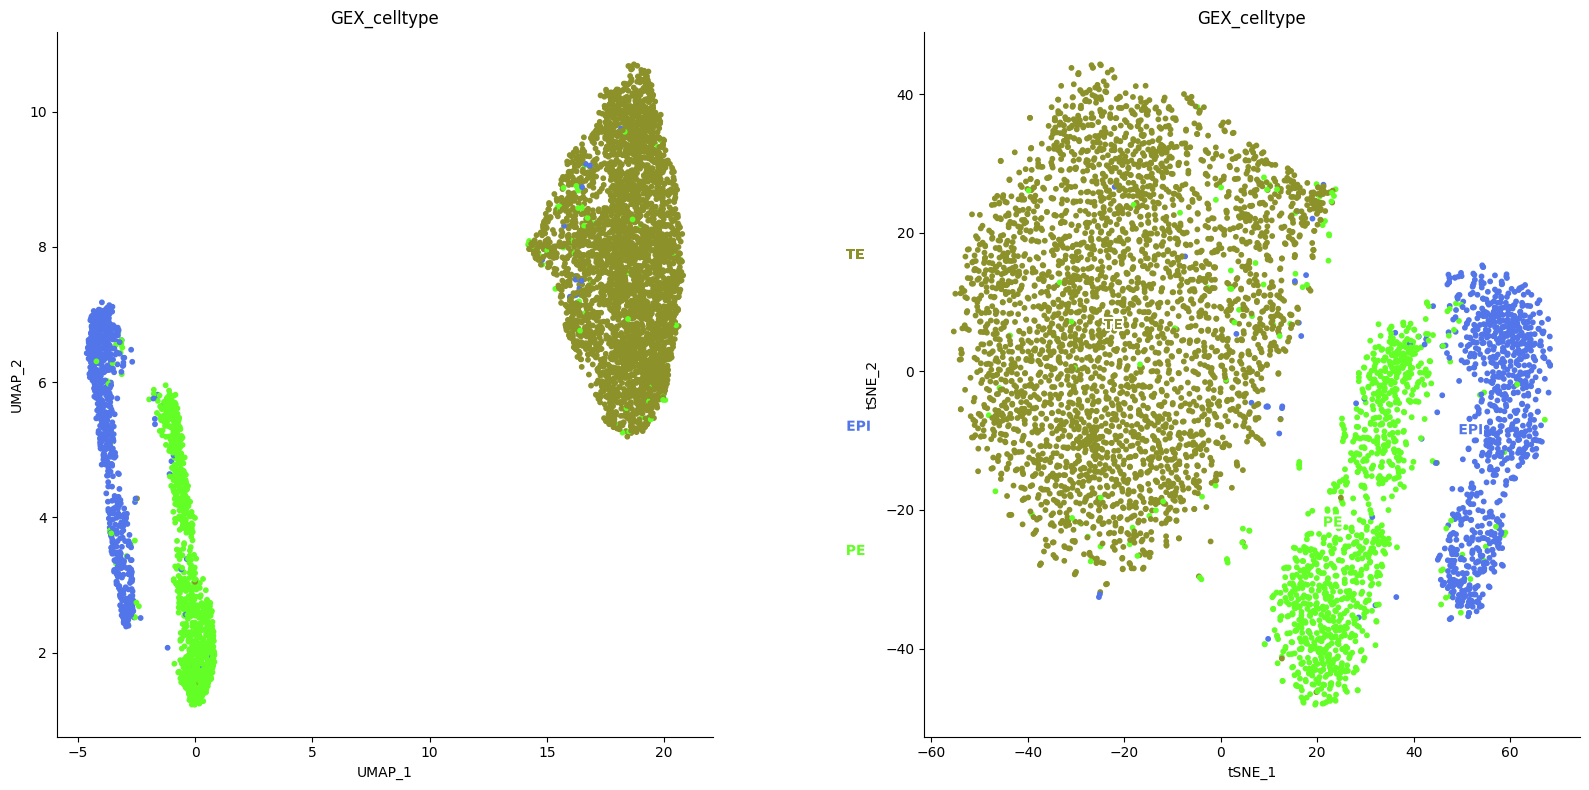

In [18]:
from scenicplus.dimensionality_reduction import plot_metadata_given_ax
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#specify color_dictionary

# color_dict = {
#     'B_cells_1': "#065143",
#     'B_cells_2': "#70B77E",
#     'CD4_T_cells': "#E0A890",
#     'CD8_T_cells': "#F56476",
#     'NK_cells': "#CE1483",
#     'Dendritic_cells': "#053C5E" ,
#     'FCGR3A+_Monocytes': "#38A3A5",
#     'CD14+_Monocytes': "#80ED99"
# }

fig, axs = plt.subplots(ncols=2, figsize = (16, 8))
plot_metadata_given_ax(
    scplus_obj=scplus_obj,
    ax = axs[0],
    reduction_name = 'eRegulons_UMAP',
    variable = 'GEX_celltype' 
#note the GEX_ prefix, this metadata originated from the gene expression metadata (on which we did the cell type annotation before)
#     color_dictionary={'GEX_celltype': color_dict}
    # figsize = (4, 4),
    # save = 'regulon.umap.pdf'
)
plot_metadata_given_ax(
    scplus_obj=scplus_obj,
    ax = axs[1],
    reduction_name = 'eRegulons_tSNE',
    variable = 'GEX_celltype'
      #note the GEX_ prefix, this metadata originated from the gene expression metadata (on which we did the cell type annotation before)
#     color_dictionary={'GEX_celltype': color_dict}
    # figsize = (4, 4),
    # save = 'regulon.tsne.pdf'

)
fig.tight_layout()
sns.despine(ax = axs[0]) #remove top and right edge of axis border
sns.despine(ax = axs[1]) #remove top and right edge of axis border
# plt.show()

# plt.savefig(fig, 'plot.e45/eregulon.umap.tsne.pdf')

### plot the activity / expression of an eRegulon on the dimensionality reduction

Nex we visualize the gene expression and target gene and region activity of some eRegulons on the tSNE.

In [ ]:
from scenicplus.dimensionality_reduction import plot_eRegulon
plot_eRegulon(
    scplus_obj = scplus_obj,
    reduction_name = 'eRegulons_UMAP',
    # cmap = 'cm.viridis',
    cmap = 'viridis', 
    selected_regulons = ['Esrrb_+','Nanog_+','Gata1_+','Klf4_+','Klf12_+','Sox2_+','Zfp148_+', 'Zfp526_+','Zic3_+', 'Trps1_extended_+', 'Sp1_extended_+','Pou2f1_extended_+','Klf9_extended_+','Zfx_+' ], #, 'Trps1_extended_-','Gata3_+', 'Gata4_+', 'Gata6_+', 
    scale = True,
    auc_key = 'eRegulon_AUC_filtered',
    save = 'eregulon.epi.umap.pdf')


In [ ]:
plot_eRegulon(
    scplus_obj = scplus_obj,
    reduction_name = 'eRegulons_UMAP',
    # cmap = 'cm.viridis',
    cmap = 'viridis', 
    selected_regulons = ['Gata4_+','Gata6_+','Klf8_+','Elf1_extended_+','Rora_extended_+','Tead1_+'], #, 'Nr3c2_extended_+','Gata3_+', 'Gata4_+', 'Gata6_+', 
    scale = True,
    auc_key = 'eRegulon_AUC_filtered',
    save = 'eregulon.pe.umap.pdf')

In [ ]:
plot_eRegulon(
    scplus_obj = scplus_obj,
    reduction_name = 'eRegulons_UMAP',
    # cmap = 'cm.viridis',
    cmap = 'viridis', 
    selected_regulons = ['Gata2_+','Gata3_+','Grhl2_+','Klf13_+', 'Klf5_+','Nr5a2_+','Sp3_+','Stat3_+','Tead2_+','Tead4_+','Tfap2a_+','Tfap2c_+',"Tfcp2l1_+" ], #, 'Nr3c2_extended_+','Gata3_+', 'Gata4_+', 'Gata6_+', 
    scale = True,
    auc_key = 'eRegulon_AUC_filtered',
    save = 'eregulon.te.umap.pdf')

We can also plot only the activity of an eRegulon

In [105]:
dill.dump(scplus_obj, open(os.path.join(work_dir, 'scenicplus/scplus_obj_mod.pkl'), 'wb'), protocol=-1)

### dotplot-heatmap

For eRegulons it is often usefull to visualize both information on the TF/target genes expression and region accessibility at the same time.

A dotplot-heatmap is a useful way to visualize this. Here the color of the heatmap can be used to visualize one aspect of the eRegulon (for example TF expression) and the size of the dot can be used to visualize another aspect (for example the enrichment (AUC value) of eRegulon target regions).

Before we plot the the dotplot-heatmap let's first select some high quality eRegulons to limit the amount of space we need for the plot. One metric which can be used for selecting eRegulons is the correlation between TF expression and target region enrichment scores (AUC values). Let's (re)calculate this value based on the simplified eRegulons

We first generate pseudobulk gene expression and region accessibility data, per celltype, to limit the amount of noise for the correlation calculation.

In [19]:
from scenicplus.cistromes import TF_cistrome_correlation, generate_pseudobulks

generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'GEX_celltype',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Gene_based')
generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'GEX_celltype',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Region_based')

TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'GEX_celltype',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Gene_based',
            out_key = 'filtered_gene_based')
TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'GEX_celltype',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Region_based',
            out_key = 'filtered_region_based')

In [20]:
scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based'].head()

,TF,Cistrome,Rho,P-value,Adjusted_p-value
0,Tead4,Tead4_+_(58r),0.526944,7.774379e-23,2.870540e-22
1,Rarb,Rarb_extended_+_(30r),0.360710,1.197226e-10,2.210263e-10
2,Nr5a2,Nr5a2_+_(34r),0.002432,9.665346e-01,9.665346e-01
3,Tead1,Tead1_+_(72r),0.215200,1.727140e-04,2.763424e-04
4,Tcf3,Tcf3_extended_+_(11r),-0.107660,6.255317e-02,7.901453e-02


Let's visualize these correlations in a scatter plot and select eRegulons for which the correlaiton coefficient is above 0.70 or below -0.75

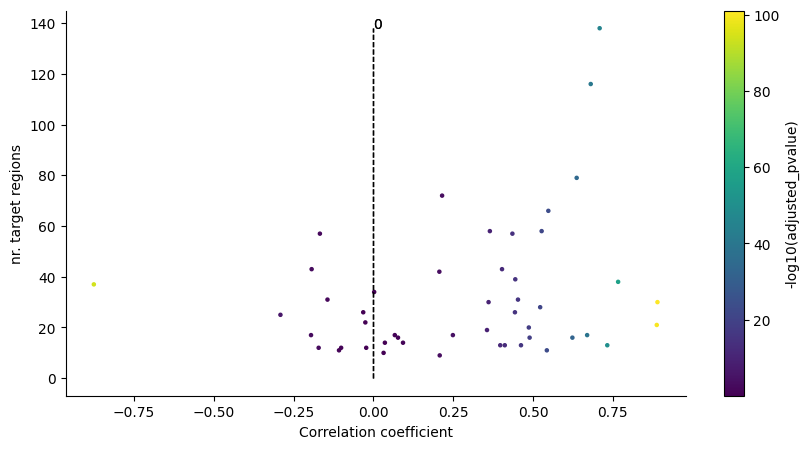

In [36]:
scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based'].to_csv(os.path.join(save_path, 'plot.e45/selected.eRegulons.region.based.csv'))

import numpy as np
n_targets = [int(x.split('(')[1].replace('r)', '')) for x in scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Cistrome']]
rho = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'].to_list()
adj_pval = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Adjusted_p-value'].to_list()

thresholds = {
        'rho': [0, 0],
        'n_targets': 0
}
import seaborn as sns
fig, ax = plt.subplots(figsize = (10, 5))
sc = ax.scatter(rho, n_targets, c = -np.log10(adj_pval), s = 5)
ax.set_xlabel('Correlation coefficient')
ax.set_ylabel('nr. target regions')
#ax.hlines(y = thresholds['n_targets'], xmin = min(rho), xmax = max(rho), color = 'black', ls = 'dashed', lw = 1)
ax.vlines(x = thresholds['rho'], ymin = 0, ymax = max(n_targets), color = 'black', ls = 'dashed', lw = 1)
ax.text(x = thresholds['rho'][0], y = max(n_targets), s = str(thresholds['rho'][0]))
ax.text(x = thresholds['rho'][1], y = max(n_targets), s = str(thresholds['rho'][1]))
sns.despine(ax = ax)
fig.colorbar(sc, label = '-log10(adjusted_pvalue)', ax = ax)

plt.show()
fig.savefig(os.path.join(save_path,'plot.e45/selected.eregulon.scatter.region.based.pdf'))

In [24]:
thresholds['rho'][1]

0

In [88]:
nx_tables['Edge']['R2G']

,Region,Gene,Consensus_name,Gene_signature_name,R2G_importance,R2G_importance_x_abs_rho,R2G_importance_x_rho,R2G_rho,Region_signature_name,is_extended
0,chr6:122782257-122782657,Nanog,Esrrb_+_+,Esrrb_+_(21g),0.009150,0.000902,0.000902,0.098613,Esrrb_+_(21r),False
1,chr15:84183828-84184228,Samm50,Esrrb_+_+,Esrrb_+_(21g),0.173809,0.029252,0.029252,0.168297,Esrrb_+_(21r),False
2,chr4:141283731-141284131,Epha2,Esrrb_+_+,Esrrb_+_(21g),0.035275,0.006194,0.006194,0.175588,Esrrb_+_(21r),False
3,chr18:20557963-20558363,B4galt6,Esrrb_+_+,Esrrb_+_(21g),0.013843,0.000824,0.000824,0.059547,Esrrb_+_(21r),False
4,chr5:53672223-53672623,Rbpj,Esrrb_+_+,Esrrb_+_(21g),0.096800,0.024962,0.024962,0.257875,Esrrb_+_(21r),False
...,...,...,...,...,...,...,...,...,...,...
32,chr8:106177607-106178007,Slc7a6,Trps1_-_+,Trps1_extended_-_(29g),0.020921,0.001864,0.001864,0.089108,Trps1_extended_-_(37r),True
33,chr15:85559477-85559877,Wnt7b,Trps1_-_+,Trps1_extended_-_(29g),0.009625,0.000937,0.000937,0.097397,Trps1_extended_-_(37r),True
34,chr4:34843153-34843553,Mob3b,Trps1_-_+,Trps1_extended_-_(29g),0.007872,0.000549,0.000549,0.069707,Trps1_extended_-_(37r),True
35,chr14:120313013-120313413,Mbnl2,Trps1_-_+,Trps1_extended_-_(29g),0.013171,0.000829,0.000829,0.062903,Trps1_extended_-_(37r),True


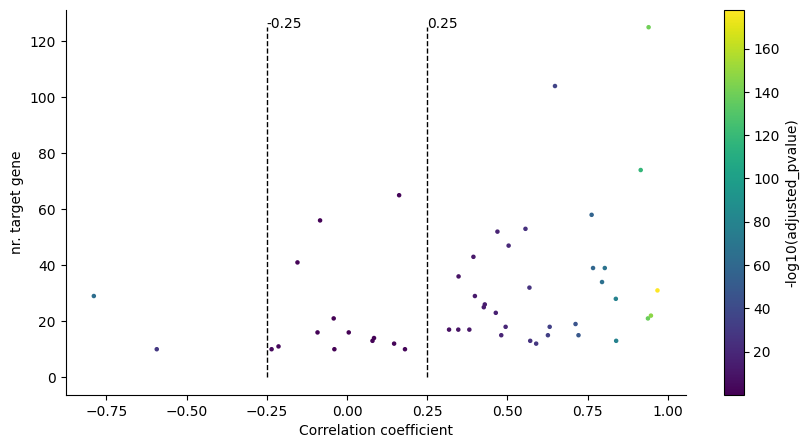

In [34]:
scplus_obj.uns['TF_cistrome_correlation']['filtered_gene_based'].to_csv(os.path.join(save_path, 'plot.e45/selected.eRegulons.gene.based.csv'))

import numpy as np
n_targets = [int(x.split('(')[1].replace('g)', '')) for x in scplus_obj.uns['TF_cistrome_correlation']['filtered_gene_based']['Cistrome']]
rho = scplus_obj.uns['TF_cistrome_correlation']['filtered_gene_based']['Rho'].to_list()
adj_pval = scplus_obj.uns['TF_cistrome_correlation']['filtered_gene_based']['Adjusted_p-value'].to_list()

thresholds = {
        'rho': [-0.25, 0.25],
        'n_targets': 0
}
import seaborn as sns
fig, ax = plt.subplots(figsize = (10, 5))
sc = ax.scatter(rho, n_targets, c = -np.log10(adj_pval), s = 5)
ax.set_xlabel('Correlation coefficient')
ax.set_ylabel('nr. target gene')
#ax.hlines(y = thresholds['n_targets'], xmin = min(rho), xmax = max(rho), color = 'black', ls = 'dashed', lw = 1)
ax.vlines(x = thresholds['rho'], ymin = 0, ymax = max(n_targets), color = 'black', ls = 'dashed', lw = 1)
ax.text(x = thresholds['rho'][0], y = max(n_targets), s = str(thresholds['rho'][0]))
ax.text(x = thresholds['rho'][1], y = max(n_targets), s = str(thresholds['rho'][1]))
sns.despine(ax = ax)
fig.colorbar(sc, label = '-log10(adjusted_pvalue)', ax = ax)

plt.show()
fig.savefig(os.path.join(save_path,'plot.e45/selected.eregulon.scatter.gene.based.pdf'))

In [32]:
scplus_obj.uns['TF_cistrome_correlation']['filtered_gene_based']

,TF,Cistrome,Rho,P-value,Adjusted_p-value
0,Tead4,Tead4_+_(47g),0.503792,1.030218e-20,2.150021e-20
1,Rarb,Rarb_extended_+_(26g),0.429553,6.702262e-15,1.148959e-14
2,Nr5a2,Nr5a2_+_(32g),0.568706,4.202557e-27,9.605845e-27
3,Tead1,Tead1_+_(65g),0.162587,4.755646e-03,5.853103e-03
4,Tcf3,Tcf3_extended_+_(10g),-0.234883,3.974939e-05,5.299918e-05
5,Tfap2a,Tfap2a_+_(74g),0.915424,8.308722e-120,7.976373e-119
6,Zic3,Zic3_+_(12g),0.589661,1.753134e-29,4.428969e-29
7,Zfp148,Zfp148_+_(56g),-0.083789,1.476858e-01,1.611118e-01
8,Gata2,Gata2_+_(58g),0.762486,2.701780e-58,1.080712e-57
9,Esrrb,Esrrb_+_(21g),0.938005,3.705277e-139,4.446333e-138


In [37]:
selected_cistromes = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based'].loc[
        np.logical_or(
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] > thresholds['rho'][1],
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] < thresholds['rho'][0]
        )]['Cistrome'].to_list()
selected_eRegulons = [x.split('_(')[0] for x in selected_cistromes]
selected_eRegulons_gene_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Gene_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
selected_eRegulons_region_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Region_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
#save the results in the scenicplus object
scplus_obj.uns['selected_eRegulon'] = {'Gene_based': selected_eRegulons_gene_sig, 'Region_based': selected_eRegulons_region_sig}
print(f'selected: {len(selected_eRegulons_gene_sig)} eRegulons')

selected: 48 eRegulons


In [38]:
selected_cistromes

['Tead4_+_(58r)',
 'Rarb_extended_+_(30r)',
 'Nr5a2_+_(34r)',
 'Tead1_+_(72r)',
 'Tcf3_extended_+_(11r)',
 'Tfap2a_+_(79r)',
 'Zic3_+_(11r)',
 'Zfp148_+_(57r)',
 'Gata2_+_(66r)',
 'Gata1_+_(26r)',
 'Esrrb_+_(21r)',
 'Gata6_+_(43r)',
 'Zfp595_extended_+_(12r)',
 'Zfp526_+_(9r)',
 'Gata4_extended_-_(10r)',
 'Nr3c2_extended_+_(16r)',
 'Trps1_extended_-_(37r)',
 'Gata4_+_(22r)',
 'Pou2f1_extended_+_(17r)',
 'Zfp217_extended_+_(17r)',
 'Klf13_+_(25r)',
 'Grhl2_+_(31r)',
 'Gata3_+_(138r)',
 'Rxra_extended_+_(19r)',
 'Klf12_+_(38r)',
 'Stat3_+_(13r)',
 'Klf8_+_(39r)',
 'Klf6_extended_+_(57r)',
 'Klf11_extended_+_(14r)',
 'Tead3_extended_+_(58r)',
 'Nanog_+_(16r)',
 'Klf4_+_(26r)',
 'Tfap2c_+_(13r)',
 'Cux1_extended_+_(12r)',
 'Sp1_extended_+_(17r)',
 'Trps1_extended_+_(30r)',
 'Tfcp2l1_+_(31r)',
 'Elf1_extended_+_(16r)',
 'Tead2_+_(42r)',
 'Zfx_+_(12r)',
 'Ubp1_extended_+_(17r)',
 'Thrb_extended_+_(13r)',
 'Klf5_+_(116r)',
 'Sox2_+_(13r)',
 'Rora_extended_+_(20r)',
 'Klf9_extended_+_(43r)',
 

In [39]:
len(selected_eRegulons_gene_sig)

48

Let's save these changes we have made to the scenicplus_obj

In [54]:
dill.dump(scplus_obj, open(os.path.join(work_dir, 'scenicplus/scplus_obj_.pkl'), 'wb'), protocol=-1)

Let's plot the heatmap-dotplot

In [40]:
# f = plt.figure()
# plt.plot(range(10), range(10), "o")
# plt.show()
# f.savefig("foo.pdf", bbox_inches='tight')
from scenicplus.plotting.dotplot import heatmap_dotplot
heatmap_dotplot(
        scplus_obj = scplus_obj,
        size_matrix = scplus_obj.uns['eRegulon_AUC_filtered']['Gene_based'], #specify what to plot as dot sizes, target region enrichment in this case
        color_matrix = scplus_obj.to_df('EXP'), #specify  what to plot as colors, TF expression in this case
        scale_size_matrix = True,
        scale_color_matrix = True,
        group_variable = 'GEX_celltype',
        subset_eRegulons = scplus_obj.uns['selected_eRegulon']['Gene_based'],
#         index_order = ['B_cells_1', 'B_cells_2', 'CD4_T_cells', 'CD8_T_cells', 'NK_cells', 'Dendritic_cells', 'FCGR3A+_Monocytes', 'CD14+_Monocytes'],
        figsize = (5,13),
        orientation = 'vertical',
        save = os.path.join(save_path, 'plot.e45/regulon.heatmap.gene.based.rho0.pdf')
        )

/bi/home/wangy/anaconda3/envs/scenicplus/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 5 x 13 in image.
/bi/home/wangy/anaconda3/envs/scenicplus/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /bi/home/wangy/MTR.method.paper/data/scenicplus.e45/plot.e45/regulon.heatmap.gene.based.rho0.pdf


2024-08-09 15:54:31,261 matplotlib.font_manager INFO     Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


In [54]:
scplus_obj.uns['eRegulon_AUC_filtered']['Region_based']

,Zfp595_extended_+_(12r),Nanog_+_(16r),Sp3_+_(14r),Sp1_extended_+_(17r),Sox2_+_(13r),Klf13_+_(25r),Ubp1_extended_+_(17r),Gata2_+_(66r),Gata4_extended_-_(10r),Klf11_extended_+_(14r),...,Tfap2a_+_(79r),Grhl2_+_(31r),Trps1_extended_-_(37r),Gata4_+_(22r),Klf5_+_(116r),Tfcp2l1_+_(31r),Tead1_+_(72r),Tfap2c_+_(13r),Rxra_extended_+_(19r),Klf9_extended_+_(43r)
Cell,,,,,,,,,,,,,,,,,,,,,
05:23:22:S1___TE,0.305729,0.043557,0.280728,0.360069,0.043135,0.428996,0.399301,0.323697,0.336006,0.308528,...,0.384488,0.274703,0.369346,0.052579,0.377372,0.430104,0.401797,0.386211,0.372927,0.199470
43:17:24:S4___TE,0.178877,0.151321,0.337739,0.457708,0.133875,0.398992,0.404269,0.331071,0.364817,0.314784,...,0.418524,0.502639,0.345469,0.132173,0.430406,0.547081,0.361097,0.381715,0.531584,0.258594
35:08:43:S2___TE,0.245500,0.316534,0.302284,0.413818,0.308629,0.450214,0.314649,0.287233,0.306388,0.288219,...,0.350223,0.314598,0.296977,0.244792,0.322765,0.399790,0.313854,0.323092,0.455349,0.242827
04:41:45:S2___PE,0.232823,0.160531,0.137495,0.329660,0.146627,0.365914,0.358858,0.249344,0.225716,0.109142,...,0.303589,0.178572,0.323319,0.093169,0.266157,0.369868,0.329853,0.263785,0.291839,0.188811
01:03:25:S4___TE,0.229860,0.043937,0.334776,0.333911,0.045072,0.332967,0.376978,0.346237,0.316101,0.290524,...,0.406818,0.347446,0.369733,0.061649,0.376548,0.465835,0.371858,0.413604,0.500711,0.179151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
07:25:10:S1___TE,0.288676,0.000000,0.117080,0.287600,0.000000,0.388732,0.357193,0.259955,0.351070,0.317936,...,0.301922,0.213735,0.298361,0.005672,0.294763,0.324222,0.323455,0.308389,0.304118,0.148766
34:03:26:S2___TE,0.296565,0.044061,0.204702,0.365221,0.043477,0.432308,0.377007,0.311200,0.347991,0.335576,...,0.372545,0.286929,0.324698,0.047041,0.361936,0.420311,0.390451,0.354373,0.410481,0.189351
27:04:20:S1___PE,0.314208,0.254826,0.194235,0.473813,0.289810,0.415891,0.406806,0.311734,0.217567,0.111600,...,0.360616,0.259960,0.402651,0.212238,0.378024,0.487849,0.403105,0.459740,0.301648,0.291839


In [41]:
from scenicplus.plotting.dotplot import heatmap_dotplot
heatmap_dotplot(
        scplus_obj = scplus_obj,
        size_matrix = scplus_obj.uns['eRegulon_AUC_filtered']['Region_based'], #specify what to plot as dot sizes, target region enrichment in this case
        color_matrix = scplus_obj.to_df('EXP'), #specify  what to plot as colors, TF expression in this case
        scale_size_matrix = True,
        scale_color_matrix = True,
        group_variable = 'GEX_celltype',
        subset_eRegulons = scplus_obj.uns['selected_eRegulon']['Gene_based'],
#         index_order = ['B_cells_1', 'B_cells_2', 'CD4_T_cells', 'CD8_T_cells', 'NK_cells', 'Dendritic_cells', 'FCGR3A+_Monocytes', 'CD14+_Monocytes'],
        figsize = (5,13),
        orientation = 'vertical',
        save = os.path.join(save_path, 'plot.e45/regulon.heatmap.region.based.rho0.pdf')
)
#,
        # save = 'regulon.heatmap.pdf')

2024-08-09 15:54:55,996 matplotlib.font_manager INFO     Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


/bi/home/wangy/anaconda3/envs/scenicplus/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 5 x 13 in image.
/bi/home/wangy/anaconda3/envs/scenicplus/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /bi/home/wangy/MTR.method.paper/data/scenicplus.e45/plot.e45/regulon.heatmap.region.based.rho0.pdf


### overlap of predicted target regions
An interesting aspect of gene regulation is transcription factor cooperativity (i.e. multiple TFs cobinding the same enhancer together driving gene expression). 

By looking at the overlap of predicted target regions of TFs we can infer potential cooperativity events.

Let's look at the overlap of target regions of the top 5 TFs per cell type based on the Regulon Specificity Score (RSS). 

First we calculate the RSS for the target regions of the selected eRegulons.

In [42]:
from scenicplus.RSS import regulon_specificity_scores
regulon_specificity_scores(
        scplus_obj,
        variable = 'GEX_celltype',
        auc_key = 'eRegulon_AUC_filtered',
        signature_keys = ['Region_based'],
        selected_regulons = [x for x in scplus_obj.uns['selected_eRegulon']['Region_based'] if '-' not in x],
        out_key_suffix = '_filtered')

Let's visualize the RSS values using a scatter plot

In [44]:
def plot_rss(scplus_obj: SCENICPLUS,
             rss_key: str,
             top_n: Optional[int] = 10,
             selected_groups: Optional[List[str]] = None,
             num_columns: Optional[int] = 1,
             figsize: Optional[Tuple[float, float]] = (6.4, 4.8),
             fontsize: Optional[int] = 12,
             save: str = None):
    """
    Plot RSS values per group

    Parameters
    ---------
    scplus_obj: `class::SCENICPLUS`
        A SCENICPLUS object with eRegulons AUC computed.
    rss_key: str, optional
        Key to extract RSS values from.
    top_n: int, optional
        Number of top eRegulons to highlight.
    selected_groups: List, optional
        Groups to plot. Default: None (all)
    num_columns: int, optional
        Number of columns for multiplotting
    figsize: tuple, optional
        Size of the figure. If num_columns is 1, this is the size for each figure; if num_columns is above 1, this is the overall size of the figure (if keeping
        default, it will be the size of each subplot in the figure). Default: (6.4, 4.8)
    fontsize: int, optional
        Size of the eRegulons names in plot.
    save: str, optional
        Path to save plot. Default: None.
    """
    data_mat = scplus_obj.uns['RSS'][rss_key]
    if selected_groups is None:
        cats = sorted(data_mat.index.tolist())
    else:
        cats = selected_groups

    if num_columns > 1:
        num_rows = int(np.ceil(len(cats) / num_columns))
        if figsize == (6.4, 4.8):
            figsize = (6.4 * num_columns, 4.8 * num_rows)
        i = 1
        fig = plt.figure(figsize=figsize)

    pdf = None
    if (save is not None) & (num_columns == 1):
        pdf = matplotlib.backends.backend_pdf.PdfPages(save)

    for c in cats:
        x = data_mat.T[c]
        if num_columns > 1:
            ax = fig.add_subplot(num_rows, num_columns, i)
            i = i + 1
        else:
            fig = plt.figure(figsize=figsize)
            ax = plt.axes()
        _plot_rss_internal(data_mat, c, top_n=top_n, max_n=None, ax=ax)
        ax.set_ylim(x.min()-(x.max()-x.min())*0.05,
                    x.max()+(x.max()-x.min())*0.05)
        for t in ax.texts:
            t.set_fontsize(fontsize)
        ax.set_ylabel('')
        ax.set_xlabel('')
        adjust_text(ax.texts,  arrowprops=dict(
            arrowstyle='-', color='lightgrey'))#changed adjustText
        if num_columns == 1:
#             fig.text(0.5, 0.0, 'eRegulon rank', ha='center',
#                      va='center', size='x-large')
#             fig.text(0.00, 0.5, 'eRegulon specificity score (eRSS)',
#                      ha='center', va='center', rotation='vertical', size='x-large')
            plt.tight_layout()
            plt.rcParams.update({
                'figure.autolayout': True,
                'figure.titlesize': 'large',
                'axes.labelsize': 'medium',
                'axes.titlesize': 'large',
                'xtick.labelsize': 'medium',
                'ytick.labelsize': 'medium'
            })
            if save is not None:
                pdf.savefig(fig, bbox_inches='tight')
            plt.show()

    if num_columns > 1:
        fig.text(0.5, 0.0, 'eRegulon rank', ha='center',
                 va='center', size='x-large')
        fig.text(0.00, 0.5, 'eRegulon specificity score (eRSS)',
                 ha='center', va='center', rotation='vertical', size='x-large')
        plt.tight_layout()
        plt.rcParams.update({
            'figure.autolayout': True,
            'figure.titlesize': 'large',
            'axes.labelsize': 'medium',
            'axes.titlesize': 'large',
            'xtick.labelsize': 'medium',
            'ytick.labelsize': 'medium'
        })
        if save is not None:
            fig.savefig(save, bbox_inches='tight')
        plt.show()
    if (save is not None) & (num_columns == 1):
        pdf = pdf.close()

In [45]:
def _plot_rss_internal(rss, cell_type, top_n=5, max_n=None, ax=None):
    """
    Helper function to plot RSS
    """
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    if max_n is None:
        max_n = rss.shape[1]
    data = rss.T[cell_type].sort_values(ascending=False)[0:max_n]
    ax.plot(np.arange(len(data)), data, '.')
    ax.set_ylim([floor(data.min() * 100.0) / 100.0,
                ceil(data.max() * 100.0) / 100.0])
    ax.set_title(cell_type)
    ax.set_xticklabels([])

    font = {
        'color': 'red',
        'weight': 'normal'
    }

    for idx, (regulon_name, rss_val) in enumerate(zip(data[0:top_n].index, data[0:top_n].values)):
        ax.plot([idx, idx], [rss_val, rss_val], 'r.')
        ax.text(
            idx + (max_n / 25),
            rss_val,
            regulon_name,
            fontdict=font,
            horizontalalignment='left',
            verticalalignment='center',
        )

In [46]:
scplus_obj.metadata_cell['GEX_cellid']

05:23:22:S1___TE    S1_05:23:22:01
43:17:24:S4___TE    S4_43:17:24:01
35:08:43:S2___TE    S2_35:08:43:02
04:41:45:S2___PE    S2_04:41:45:01
01:03:25:S4___TE    S4_01:03:25:01
                         ...      
07:25:10:S1___TE    S1_07:25:10:02
34:03:26:S2___TE    S2_34:03:26:02
27:04:20:S1___PE    S1_27:04:20:02
47:08:48:S1___PE    S1_47:08:48:01
34:39:11:S2___PE    S2_34:39:11:02
Name: GEX_cellid, Length: 5573, dtype: object

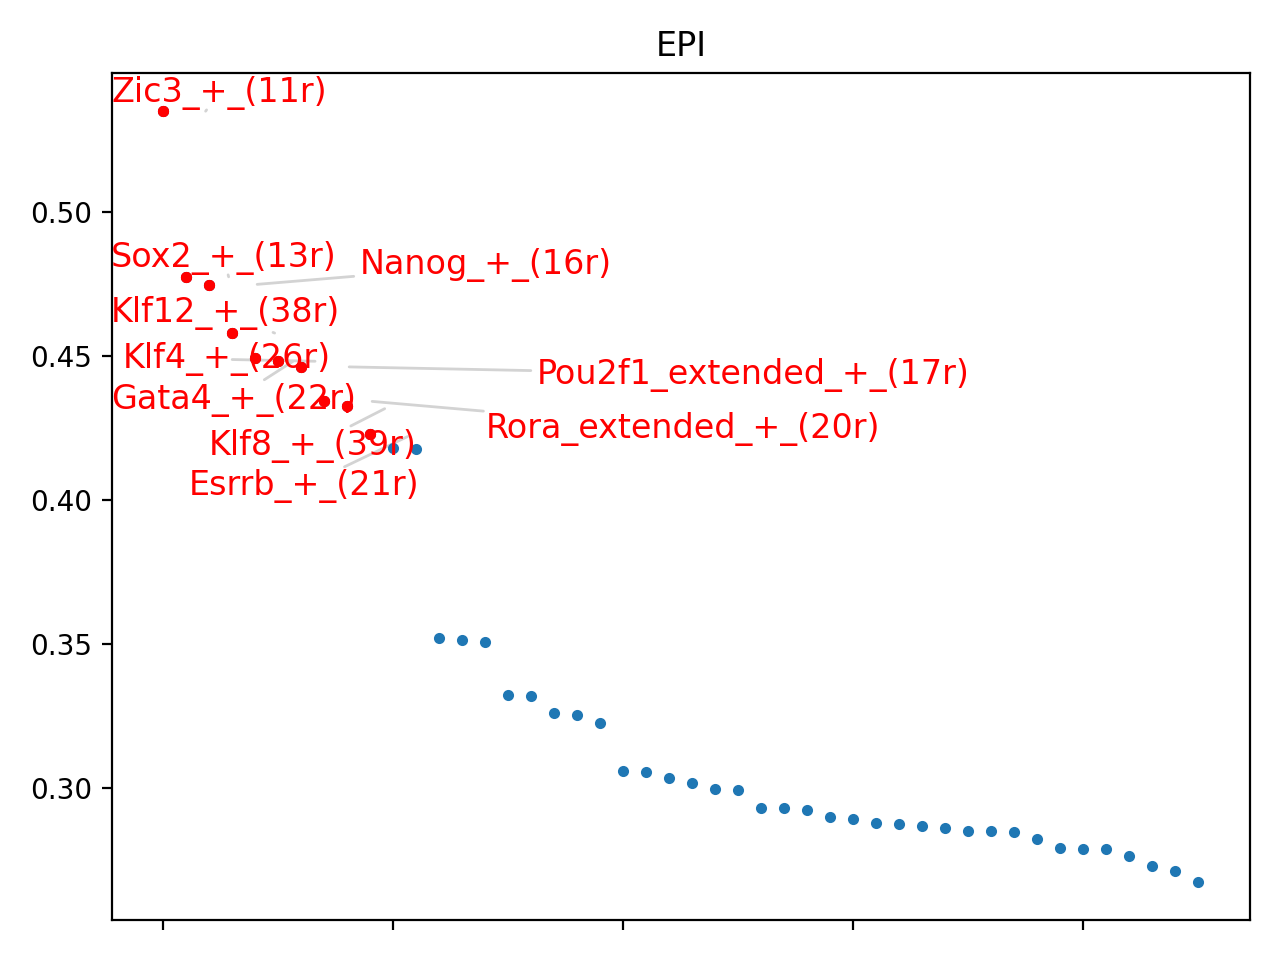

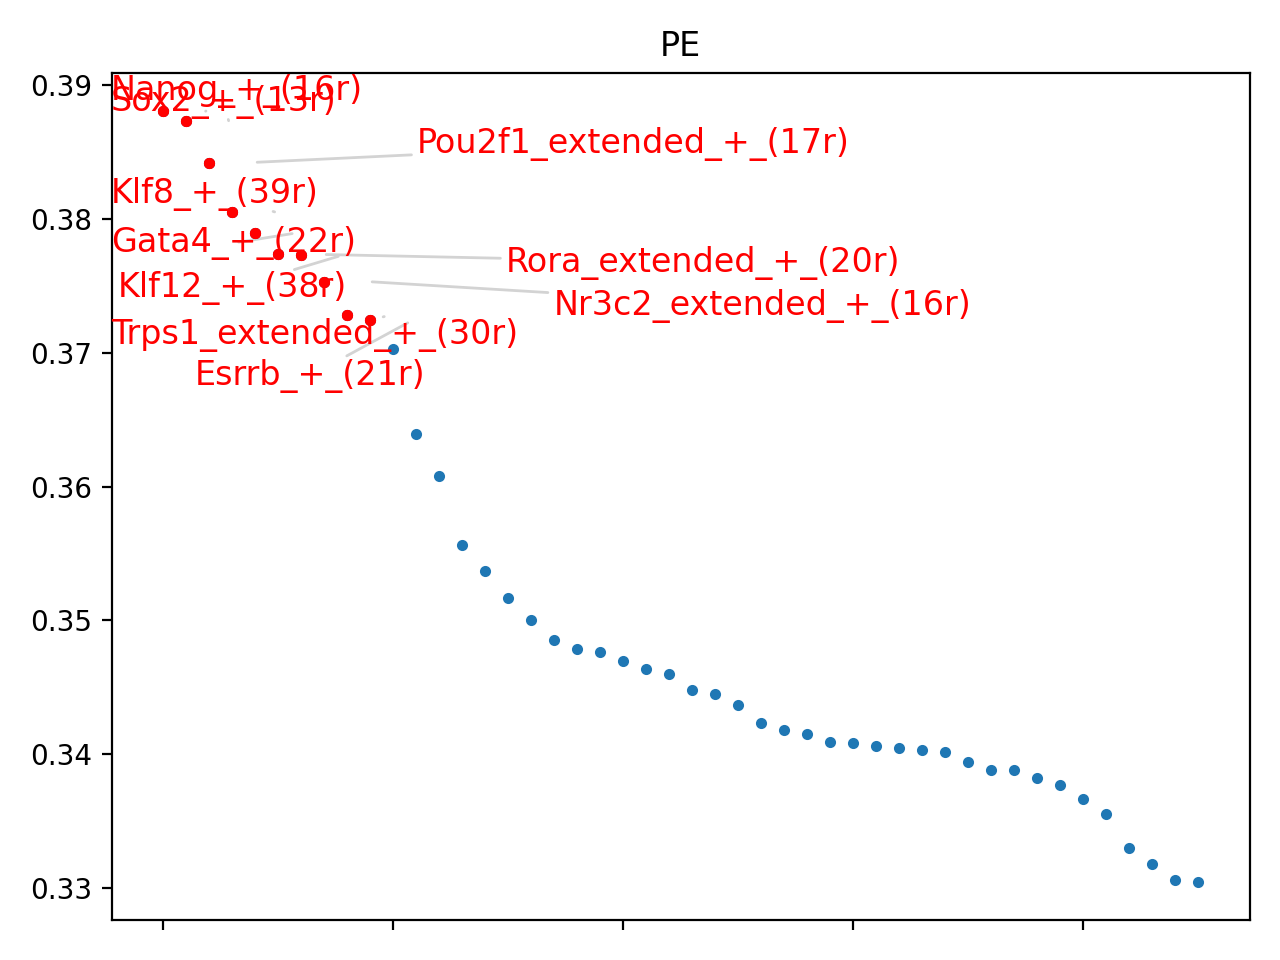

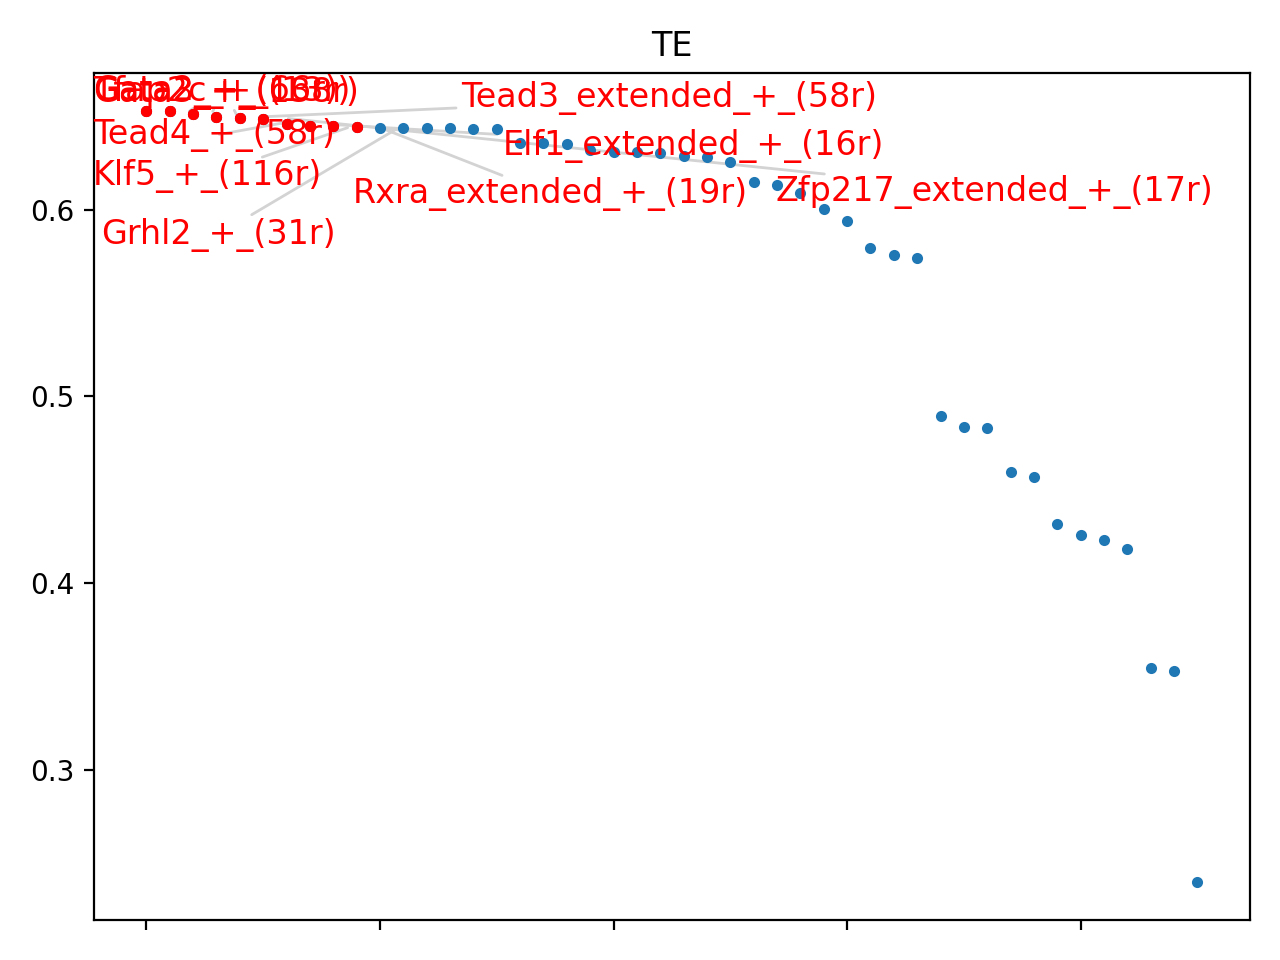

In [51]:
plot_rss(scplus_obj, 
         rss_key = 'GEX_celltype_filtered', 
         top_n= 10, 
         save = os.path.join(save_path, 'plot.e45/rss.pdf'))

Next we select the top 10 eRegulons per cell type

In [52]:
flat_list = lambda t: [item for sublist in t for item in sublist]
selected_markers = list(set(flat_list(
    [scplus_obj.uns['RSS']['GEX_celltype_filtered'].loc[celltype].sort_values(ascending = False).head(10).index.to_list() 
    for celltype in scplus_obj.uns['RSS']['GEX_celltype_filtered'].index])))

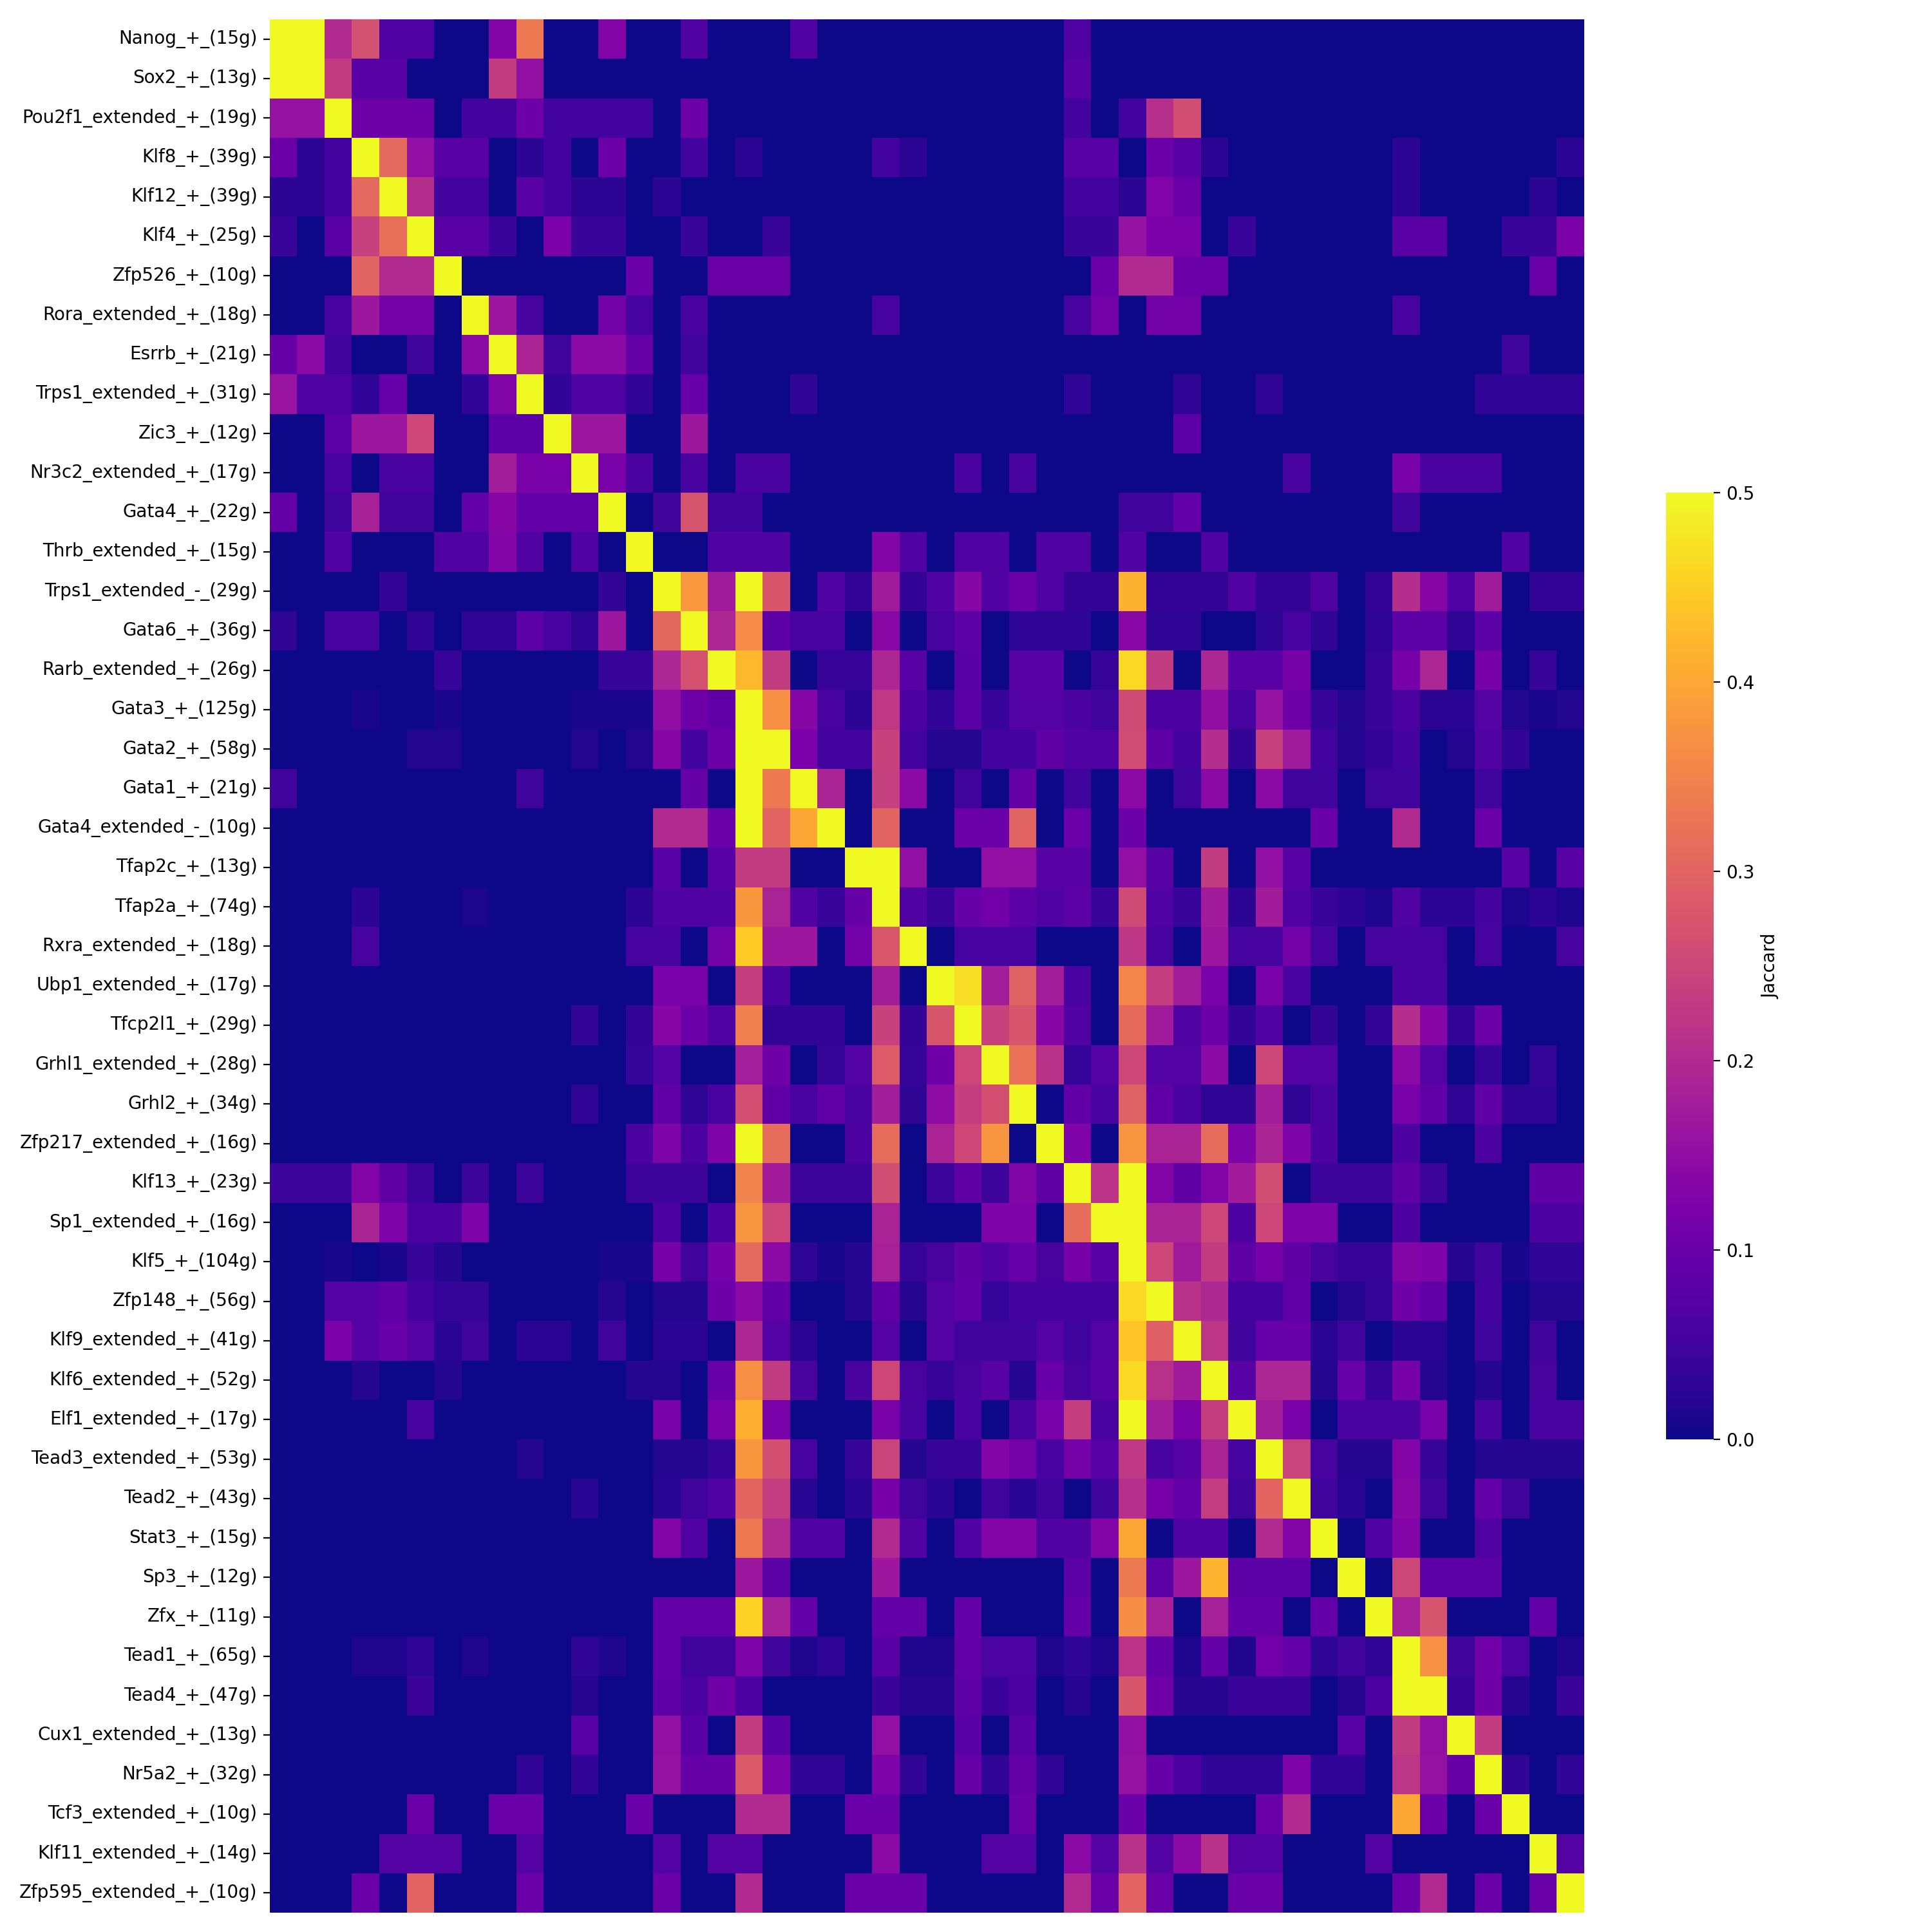

In [57]:
from scenicplus.plotting.correlation_plot import *

region_intersetc_data, Z = jaccard_heatmap(
        scplus_obj,
        method = 'intersect',
        gene_or_region_based = 'Gene_based',
        use_plotly = False,
        # selected_regulons = selected_markers,
        signature_key = 'eRegulon_signatures_filtered',
        figsize = (15, 15), return_data = True, vmax = 0.5, cmap = 'plasma',
        save = os.path.join(save_path, 'plot.e45/eregulon.gene.based.heatmap.correlation.plot.pdf'))

In [58]:
region_intersetc_data
region_intersetc_data.to_csv(os.path.join(save_path, 'plot.e45/eregulon.gene.based.heatmap.correlation.jaccard.csv'))

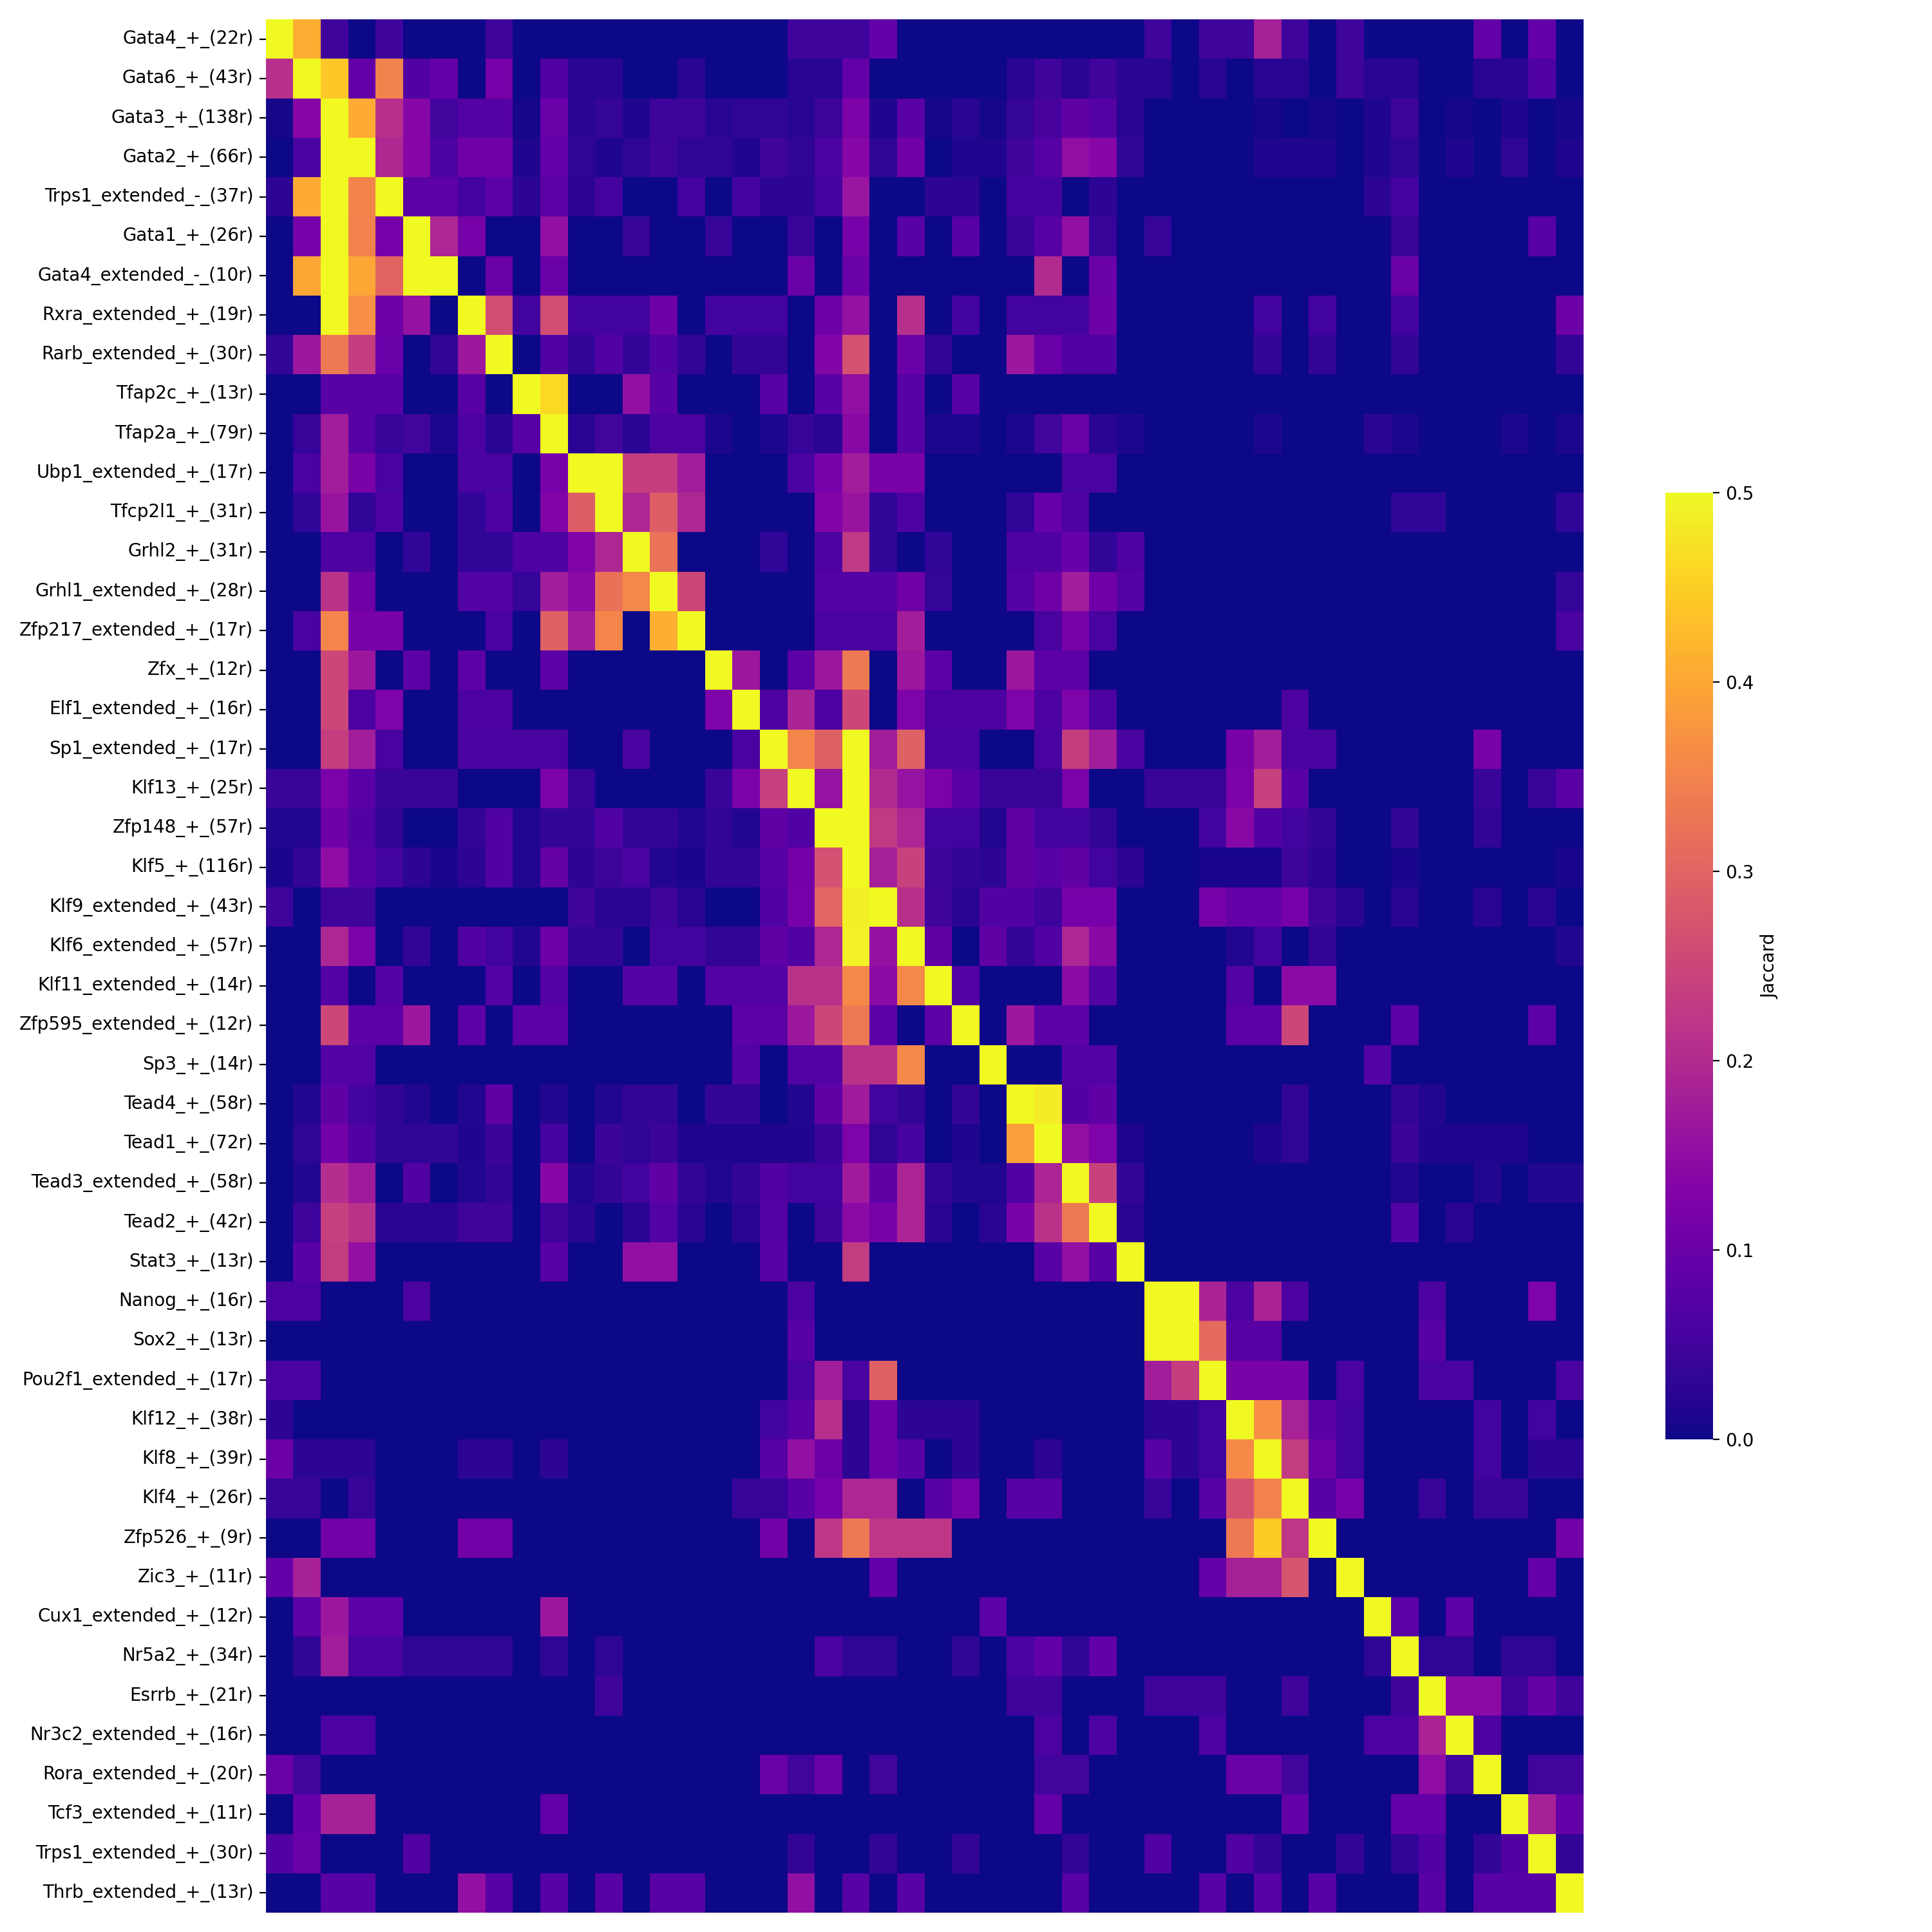

In [59]:
from scenicplus.plotting.correlation_plot import *

region_intersetc_data, Z = jaccard_heatmap(
        scplus_obj,
        method = 'intersect',
        gene_or_region_based = 'Region_based',
        use_plotly = False,
#         selected_regulons = selected_markers,
        signature_key = 'eRegulon_signatures_filtered',
        figsize = (15, 15), return_data = True, vmax = 0.5, cmap = 'plasma',
        save = os.path.join(save_path, 'plot.e45/eregulon.region.based.heatmap.correlation.plot.pdf'))

In [ ]:
region_intersetc_data.to_csv(os.path.join(save_path, 'plot.e45/eregulon.region.based.heatmap.correlation.jaccard.csv'))
region_intersetc_data

### Plotting a network

eRegulons can also be visualized in a network. Simple plots can be made using python. For more complicated plots (i.e. containing many nodes and edges) we suggest exporting your network to cytoscape.

Let's create a very simple network for B cells. We will use the top 1000 highly variable regions and genes in this plot. If you want to use more feautures please export your nework to cytoscape.

In [61]:
from pycisTopic.diff_features import find_highly_variable_features
# hvr = find_highly_variable_features(scplus_obj.to_df('ACC').loc[list(set(scplus_obj.uns['eRegulon_metadata_filtered']['Region']))], n_top_features=700, plot = False)
# hvg = find_highly_variable_features(scplus_obj.to_df('EXP')[list(set(scplus_obj.uns['eRegulon_metadata_filtered']['Gene']))].T, n_top_features=608, plot = False)

First we format the eRegulons into a table which can be used to create a network using the package [networkx](https://networkx.org/)

In [89]:
color = ['#E6A004']*8+['#56B3E6']*2+['#069F73']*11

In [90]:
# TF = ["Klf4",'Esrrb','Nanog','Sox2','Pou2f1_extended','Sp1_extended','Tcf3_extended','Trps1_extended',
                        # 'Gata6','Gata4','Rora_extended', "Klf8", 'Nr3c2_extended',
                        # 'Gata3','Tfap2a','Rxra_extended','Sp3','Stat3','Tfap2c']

In [91]:
TF = ["Esrrb", "Klf12",   "Nanog", "Pou2f1_extended",  "Rora_extended", "Sox2", "Trps1_extended","Zic3" ,
      "Gata4" , "Klf8" , 
     "Gata2",  "Gata3", "Grhl1_extended",  "Grhl2", "Klf5", "Stat3", "Tead3_extended", "Tead4","Tfap2a","Tfap2c", "Nr5a2"   ]                                    
                                       

keep tfs based on adjust p <0.05, abs(rho)>0.5 for gene based regulon (calculated in r) , for region based, it is not necessary that TF has strong relation with ac level.  

In [92]:
from scenicplus.networks import create_nx_tables
print(create_nx_tables)

<function create_nx_tables at 0x7f2f38458860>


In [93]:
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape
# from importlib import reload
# while True:
#     if is_changed(create_nx_tables):
#        create_nx_tables = reload(create_nx_tables) 

nx_tables = create_nx_tables(
    scplus_obj = scplus_obj,
    eRegulon_metadata_key ='eRegulon_metadata_filtered',
    subset_eRegulons = TF,
#     Tfcp2l1
#     subset_regions = hvr,
#     subset_genes = hvg,
    add_differential_gene_expression = True,
    add_differential_region_accessibility = True,
    differential_variable = ['GEX_celltype'])

/bi/home/wangy/anaconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/bi/home/wangy/anaconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/bi/home/wangy/anaconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


In [94]:
# TF = ["Klf4",'Esrrb','Nanog','Sox2','Pou2f1','Sp1','Tcf3','Trps1',
#                         'Gata6','Gata4','Rora', "Klf8", 'Nr3c2',
#                         'Gata3','Tfap2a','Rxra','Sp3','Stat3','Tfap2c']
TF = ["Esrrb", "Klf12",   "Nanog", "Pou2f1",  "Rora", "Sox2", "Trps1","Zic3" ,
      "Gata4" , "Klf8" , 
     "Gata2",  "Gata3", "Grhl1",  "Grhl2", "Klf5", "Stat3", "Tead3", "Tead4","Tfap2a","Tfap2c", "Nr5a2"   ]    

Next we layout the graph.

In [95]:
G, pos, edge_tables, node_tables = create_nx_graph(nx_tables, 
                   use_edge_tables = ['TF2R','R2G'],
                       color_edge_by = {'TF2R': {'variable' : 'TF', 'category_color' : dict(zip(TF,color))},
                                     'R2G': {'variable' : 'R2G_rho', 'continuous_color' : 'Greys', 'v_min': -1, 'v_max': 1}},
                   transparency_edge_by =  {'R2G': {'variable' : 'R2G_importance', 'min_alpha': 0.1, 'v_min': 0}},
                   width_edge_by = {'R2G': {'variable' : 'R2G_importance', 'max_size' :  1.5, 'min_size' : 1}},
#                    color_node_by = {'TF': {'variable': 'TF', 'category_color' : dict(zip(TF,color))}},
#                                     'Gene': {'variable': 'GEX_celltype_Log2FC_TE', 'continuous_color' : 'bwr'},
#                                     'Region': {'variable': 'GEX_celltype_Log2FC_TE', 'continuous_color' : 'viridis'}},
#                    transparency_node_by =  {'Region': {'variable' : 'GEX_celltype_Log2FC_TE', 'min_alpha': 0.1},
#                                     'Gene': {'variable' : 'GEX_celltype_Log2FC_TE', 'min_alpha': 0.1}},
                   size_node_by = {'TF': {'variable': 'fixed_size', 'fixed_size': 30},
                                    'Gene': {'variable': 'fixed_size', 'fixed_size': 15},
                                    'Region': {'variable': 'fixed_size', 'fixed_size': 10}},
                   shape_node_by = {'TF': {'variable': 'fixed_shape', 'fixed_shape': 'ellipse'},
                                    'Gene': {'variable': 'fixed_shape', 'fixed_shape': 'ellipse'},
                                    'Region': {'variable': 'fixed_shape', 'fixed_shape': 'diamond'}},
                   label_size_by = {'TF': {'variable': 'fixed_label_size', 'fixed_label_size': 20.0},
                                    'Gene': {'variable': 'fixed_label_size', 'fixed_label_size': 10.0},
                                    'Region': {'variable': 'fixed_label_size', 'fixed_label_size': 0.0}},
                   layout='kamada_kawai_layout',
                   scale_position_by=250)

In [97]:
# export_to_cytoscape(G, pos, out_file = os.path.join(save_path, 'plot.e45/GRN.export.to.cytoscape.cyjs'))
export_to_cytoscape(G, pos, out_file = os.path.join(save_path, 'plot.e45/GRN.export.to.cytoscape2.cyjs'))
# export_to_cytoscape(G, pos, out_file = os.path.join(save_path, 'plot.e45/GRN.export.to.cytoscape3.cyjs'))

In [ ]:
f = plt.figure(figsize=(20,20))
plot_networkx(G, pos)

In [81]:
f.savefig(os.path.join('gene.regulatory.network.pdf'))

In [ ]:
plt.figure(figsize=(20,20))
plot_networkx(G, pos)

Finally we can visualize the network.

In this network diamond shapes represent regions and they are color coded by their log2fc value in B cells target genes and TFs are visualized using circles and are labeled.

In [ ]:
plt.figure(figsize=(10,10))
plot_networkx(G, pos)

In [ ]:
plt.figure(figsize=(10,10))
plot_networkx(G, pos)

We can also export this network to a format which can be opened in Cytoscape.

In [290]:
export_to_cytoscape(G, pos, out_file = os.path.join(work_dir, 'scenicplus/plot.cys'))

This network can be imported using `file -> import -> Network from file ...`

Also make sure to import the SCENIC+ network layout using `file -> import -> Styles from file ...`.

This layout is available under [cytoscape_styles/SCENIC+.xml](https://raw.githubusercontent.com/aertslab/scenicplus/main/cytoscape_styles/SCENIC%2B.xml).

In [98]:
dill.dump(scplus_obj, open(os.path.join(save_path, 'scplus_obj_processed.pkl'), 'wb'), protocol=-1)

The files in the folder `scATAC/consensus_peak_calling/pseudobulk_bw_files/*` and `scATAC/consensus_peak_calling/MACS/*.narrowPeak` are very useful for visualising cell type specific region accessibility in IGV or the UCSC genomebrowser. You can combine this (only in the UCSC genome browser) with `scenicplus/eRegulons.bb`, `scenicplus/r2g.importance.bb` and/or `scenicplus/r2g.rho.bb` to get a more complete view including region to gene links and predicted eRegulon bindin sites.

The files `scenicplus/SCENIC+_gene_based.loom` and `scenicplus/SCENIC+_region_based.loom` can be visualized in SCope.

The file: `scenicplus/network_B_cells.cys` can be visualised in Cytoscape.